In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
sns.set(font="Malgun Gothic",rc={"axes.unicode_minus":False}, style='whitegrid')

In [2]:
data_root = "./data/montly"

# 데이터 과학 입문 Project

## 1. Data 준비

### 1) Weather data

In [3]:
# 파일 불러오기
weather_df = pd.read_csv(f'{data_root}/weather_df.csv', encoding='cp949')

# 일시 format 통일을 위한 변경 (ex :2000.01 -> 2000-01)
weather_df['시점'] = weather_df['시점'].astype('str').str.replace(pat='.', repl='-', regex=False)

# 분석에 필요없는 변수 제거
weather_df = weather_df.drop(['관측지점별', '최고기온','최저기온'],axis=1)
display(weather_df.head(10))

,시점,평균기온,합계강수량,평균풍속,평균상대습도,합계일조시간
0,2000-01,-2.1,42.8,2.6,64,108.3
1,2000-02,-1.7,2.1,2.7,56,139.3
2,2000-03,6.3,3.1,3.0,55,152.8
3,2000-04,11.9,30.7,2.9,56,156.6
4,2000-05,17.5,75.2,2.3,66,138.3
5,2000-06,23.7,68.1,1.9,65,133.0
6,2000-07,26.8,114.7,2.1,73,108.2
7,2000-08,26.2,599.4,1.7,79,112.8
8,2000-09,20.7,178.5,1.7,71,116.4
9,2000-1,14.9,18.1,1.5,64,131.3


### 2) 상품군별_판매액지수

In [4]:
product_df = pd.read_csv(f'{data_root}/재별및상품군별_판매액지수.csv', encoding='cp949', index_col=0).T
product_df.columns = [product_df.columns, product_df.loc['항목']]  # multi column으로 변경 (상품군 , 지수종류)
product_df = product_df.drop(index=['항목','단위'])

display(product_df.head(3))

총지수              총지수(승용차 제외)               내구재                승용차  \
항목         경상지수  불변지수 계절조정지수        경상지수 불변지수 계절조정지수  경상지수  불변지수 계절조정지수  경상지수   
1995.01 월  32.0  49.8   48.9         NaN  NaN    NaN  44.7  30.0   34.5  28.6   
1995.02 월  27.2  42.1   46.0         NaN  NaN    NaN  40.0  27.0   33.9  23.3   
1995.03 월  30.2  46.4   46.3         NaN  NaN    NaN  46.8  31.4   34.1  28.8   

           ...    화장품 서적, 문구             차량연료             기타비내구재              
항목         ... 계절조정지수   경상지수 불변지수 계절조정지수 경상지수 불변지수 계절조정지수   경상지수 불변지수 계절조정지수  
1995.01 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.02 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.03 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  

[3 rows x 72 columns]

- **지수 종류 및 column 선택**
    - 지수 종류 [경상지수, 불변지수, 계절조정지수]

In [5]:
# 사용할 컬럼 선택
product_sales_type = '불변지수'
product_columns = ['승용차', '가전제품','가구','의복', '가방', '음식료품','의약품','화장품', '서적, 문구']
product_column_sales_type = [(p, product_sales_type) for p in product_columns]
selected_product_df = product_df[product_column_sales_type].apply(pd.to_numeric)

# index 변경 및 일시 데이터 컬럼 생성, format 변환
selected_product_df['시점'] = selected_product_df.index.map(lambda x:f"{x[0:4]}-{x[5:7]:0<2}")
selected_product_df = selected_product_df.reset_index(drop=True)
selected_product_df.columns = [c[0] for c in selected_product_df.columns]

### 3) 데이터 합치기

In [6]:
df_dict = {}

for p in product_columns:
    tmp_df = selected_product_df[[p]+['시점']]
    merged_df = pd.merge(weather_df, tmp_df).dropna()
    merged_df = merged_df.reset_index(drop=True)
    df_dict[p] = merged_df
    print(f'상품군 {p}의 데이터 크기 : {df_dict[p].shape}')

상품군 승용차의 데이터 크기 : (245, 7)
상품군 가전제품의 데이터 크기 : (190, 7)
상품군 가구의 데이터 크기 : (190, 7)
상품군 의복의 데이터 크기 : (190, 7)
상품군 가방의 데이터 크기 : (135, 7)
상품군 음식료품의 데이터 크기 : (190, 7)
상품군 의약품의 데이터 크기 : (190, 7)
상품군 화장품의 데이터 크기 : (190, 7)
상품군 서적, 문구의 데이터 크기 : (190, 7)


### 4) Classification Target Data 구성 (높은 판매지수:1, 낮은 판매지수:0)

In [7]:
# 년 평균 판매지수 대비 높은지 여부 (높음:1, 낮음 :0)
for p in product_columns:
    df_dict[p]['연도'] = df_dict[p]['시점'].str[:4]
    yearly_means = df_dict[p].groupby('연도')[p].mean()
    increase_label_list = []
    for i in df_dict[p]['연도'].unique():
        increase_label_list.extend(df_dict[p][p].loc[df_dict[p]['연도']==i]>int(yearly_means[i]))
    df_dict[p]['년평균대비증감'] = increase_label_list
    df_dict[p]['년평균대비증감'] = df_dict[p]['년평균대비증감'].astype('int')
    
    # 필요없는 '연도' column 버리기
    df_dict[p] = df_dict[p].drop(['연도'],axis=1)
    df_dict[p].columns = ['time', 'temp', 'precip', 'wind', 'humid', 'sun', 'sales','sales_increase'] 
    

## 2. Data분석
### 2.1  Weather , Retail data

- **Histogram**

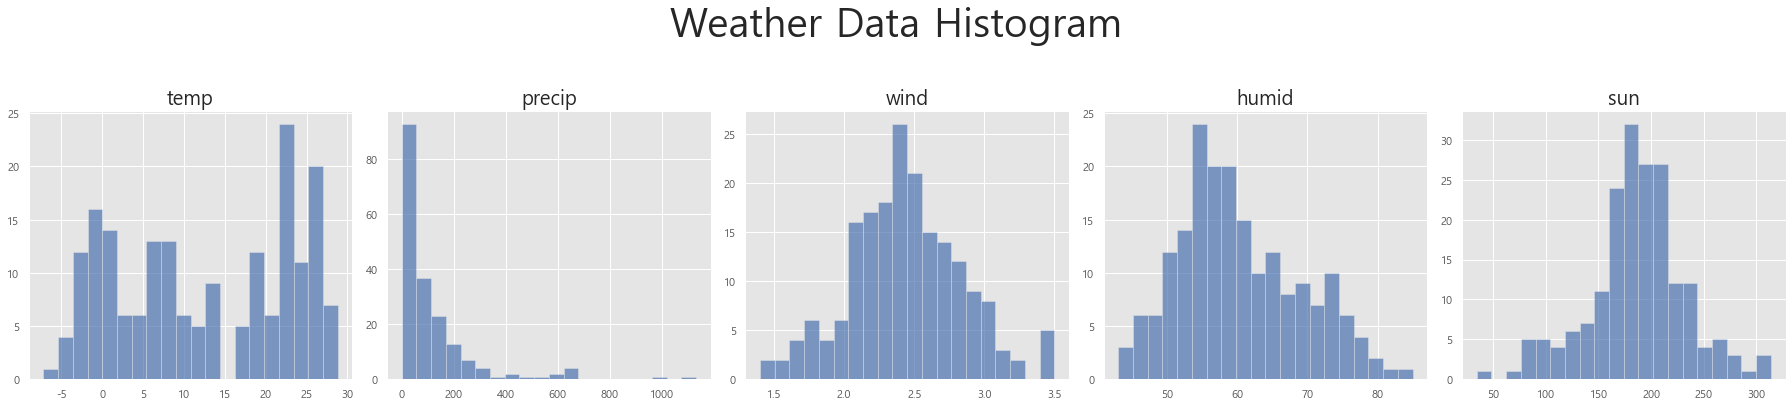

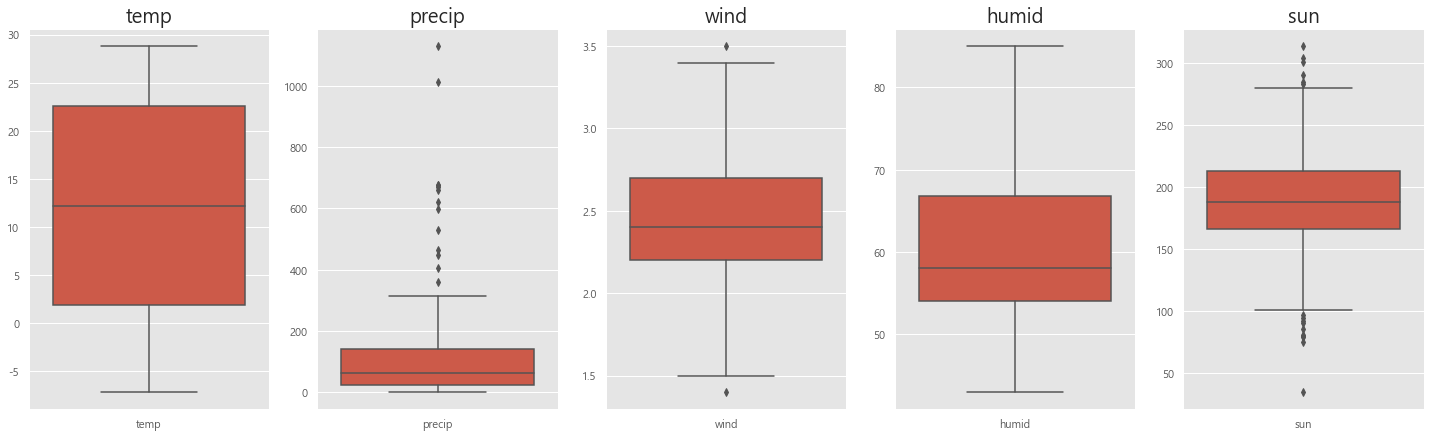

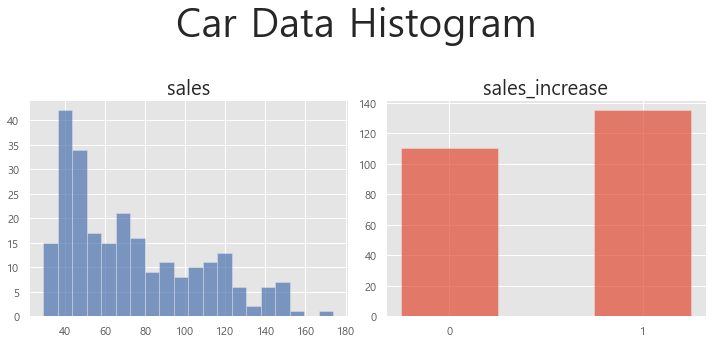

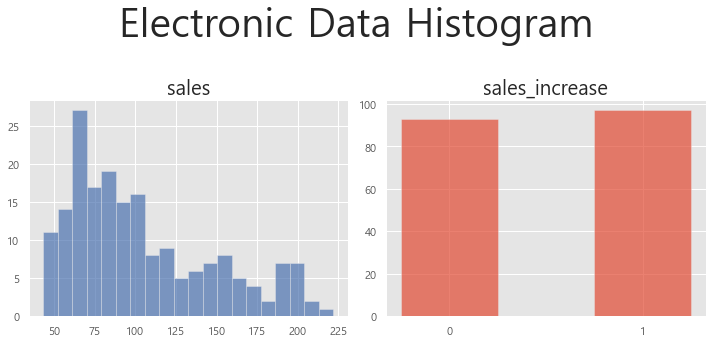

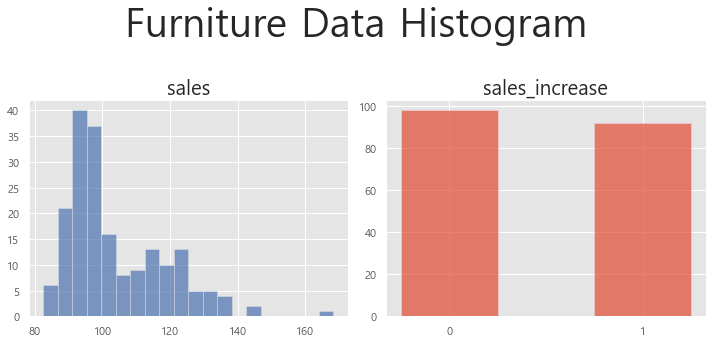

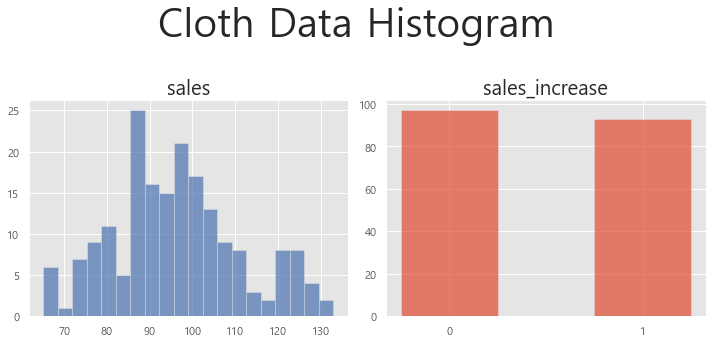

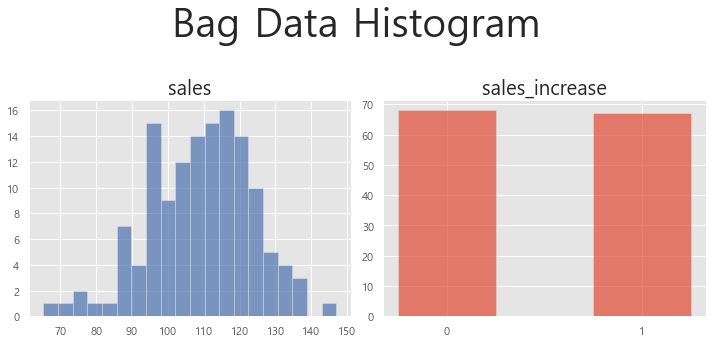

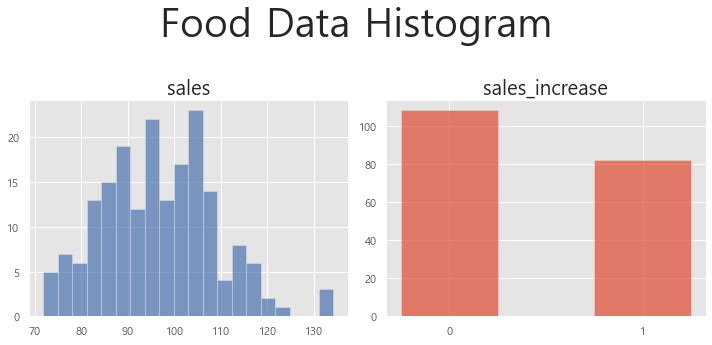

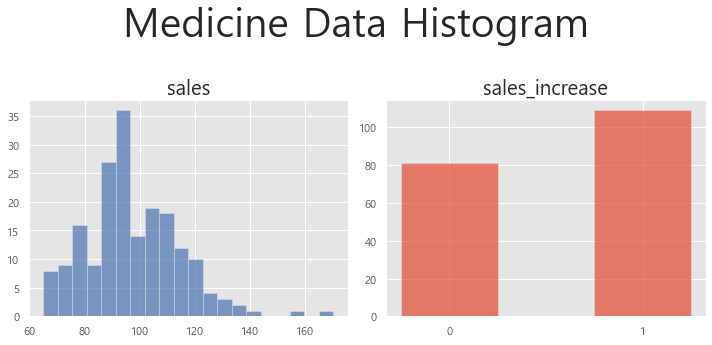

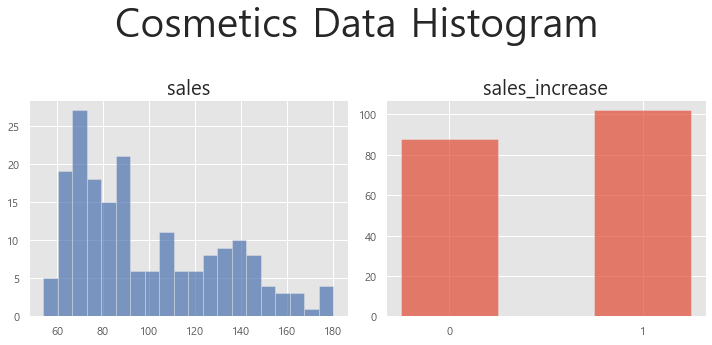

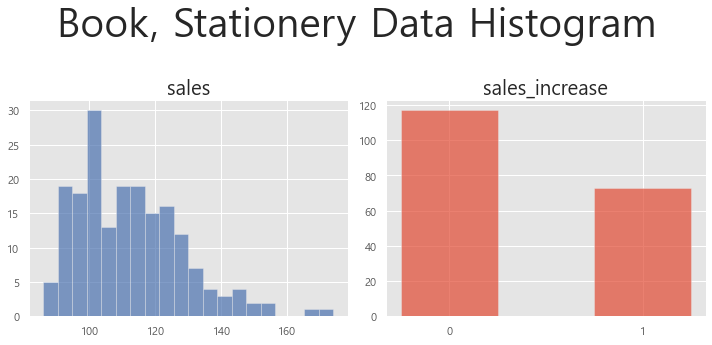

In [8]:
def plot_histogram(df, title: str = "Data Histogram"):

    cols = df.columns
    len_col, len_row = min(len(cols), 5), len(cols)//5 + 1
    plt.style.use("ggplot")
    plt.figure(figsize=(len_col*5, len_row*5))
    plt.suptitle(f"{title}", fontsize=40)

    i=0
    for col in cols:
        if type(df[col][0]) is str:
            continue
        i+=1
        plt.subplot(len_row,len_col,i)
        plt.title(col, fontsize=20)
        if len(df[col].unique()) > 3:
            plt.hist(df[col], bins=20, color='b', alpha=0.7)
        else:
            temp = df[col].value_counts()
            plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
            plt.xticks(temp.keys())
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

product_list = ['Car', 'Electronic','Furniture','Cloth', 'Bag', 'Food','Medicine','Cosmetics', 'Book, Stationery']

# 날씨 데이터 히스토그램
plot_histogram(df_dict[p][['temp', 'precip', 'wind', 'humid', 'sun']], title='Weather Data Histogram')

# box plot
plt.figure(figsize=(25, 7))
for i,c in enumerate(['temp', 'precip', 'wind', 'humid', 'sun']):
    plt.subplot(1,5,i+1)
    plt.title(f"{c}", fontsize=20)
    sns.boxplot(data=df_dict[p][c],)
    plt.xticks(range(1), [c])
plt.show()

# 판매지수 및 판매지수 증감 데이터 히스토그램
for i,p in enumerate(product_columns):
    plot_histogram(df_dict[p][['sales','sales_increase']], title=f'{product_list[i]} Data Histogram')

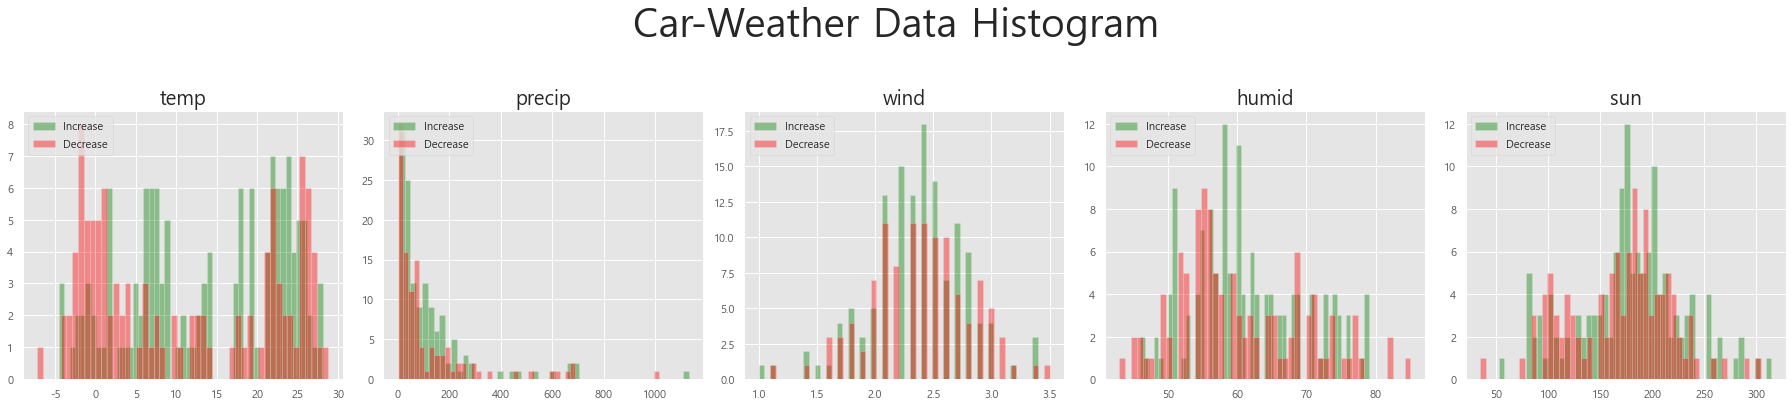

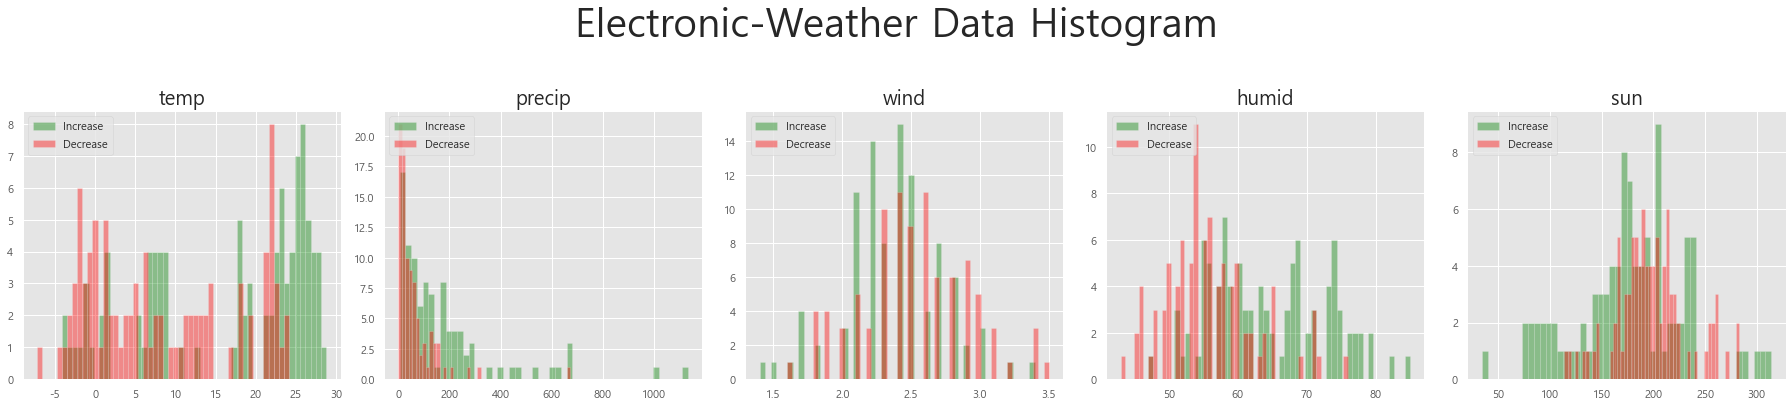

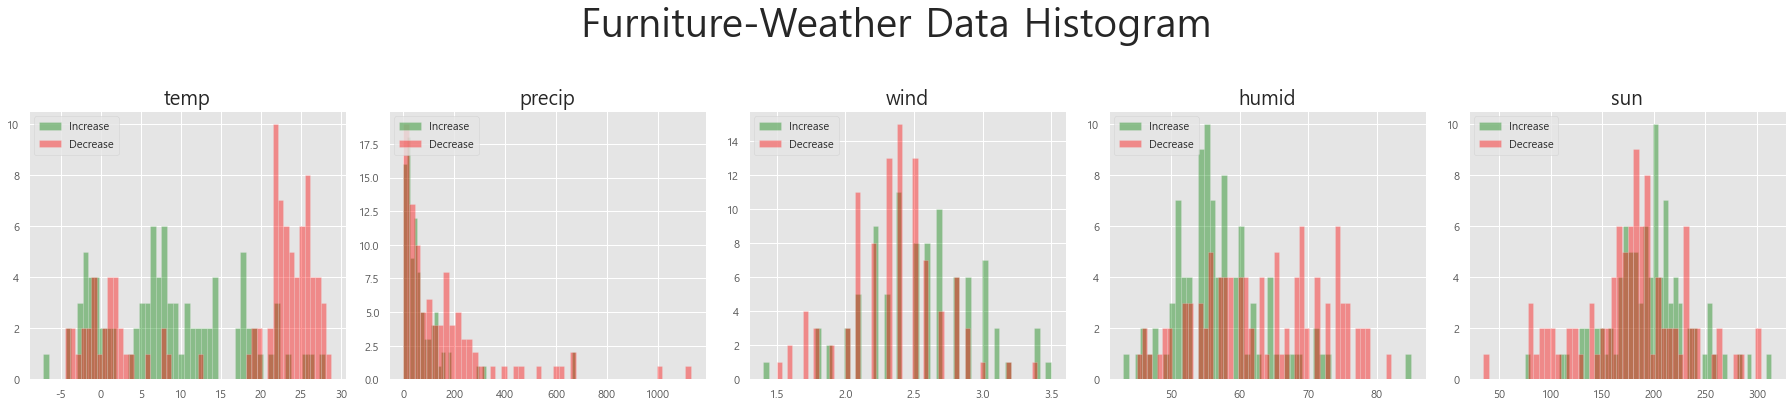

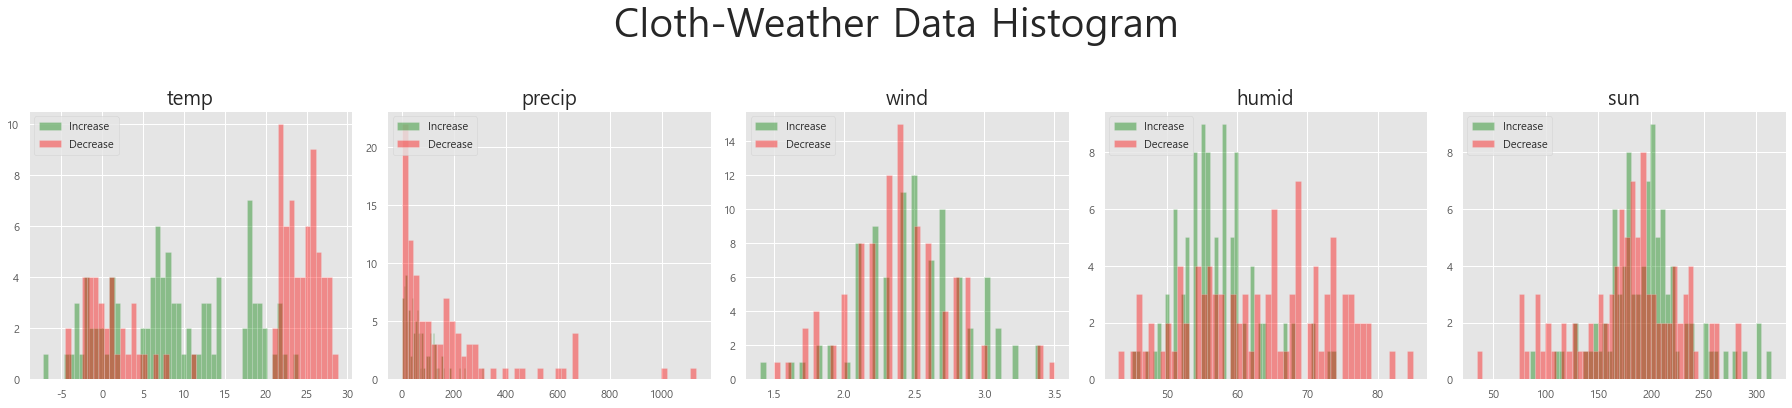

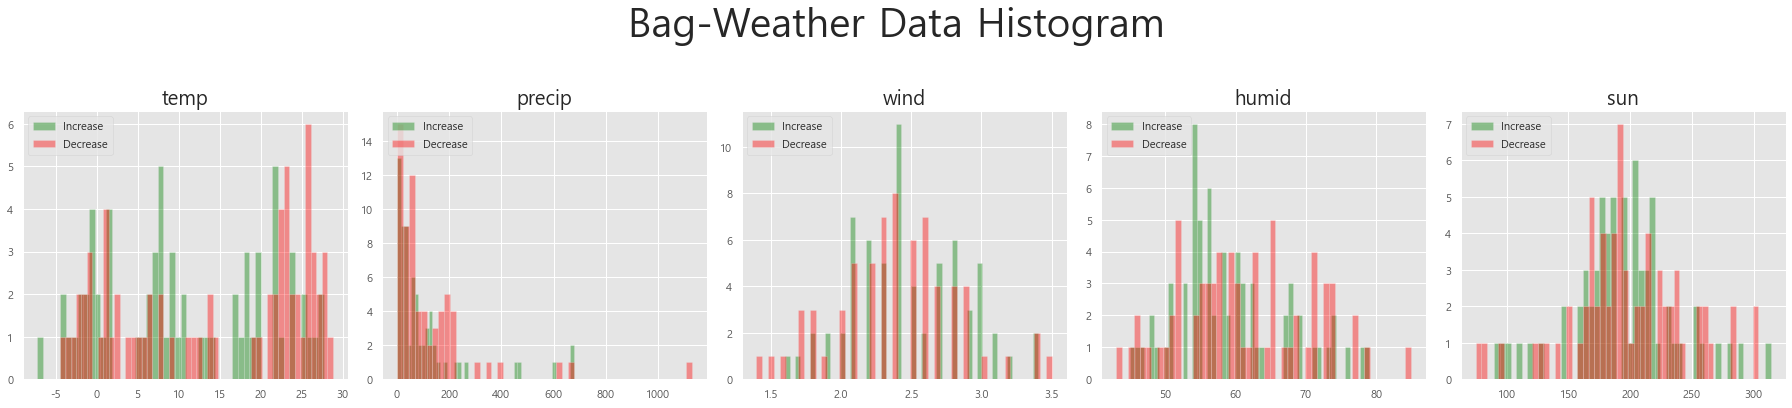

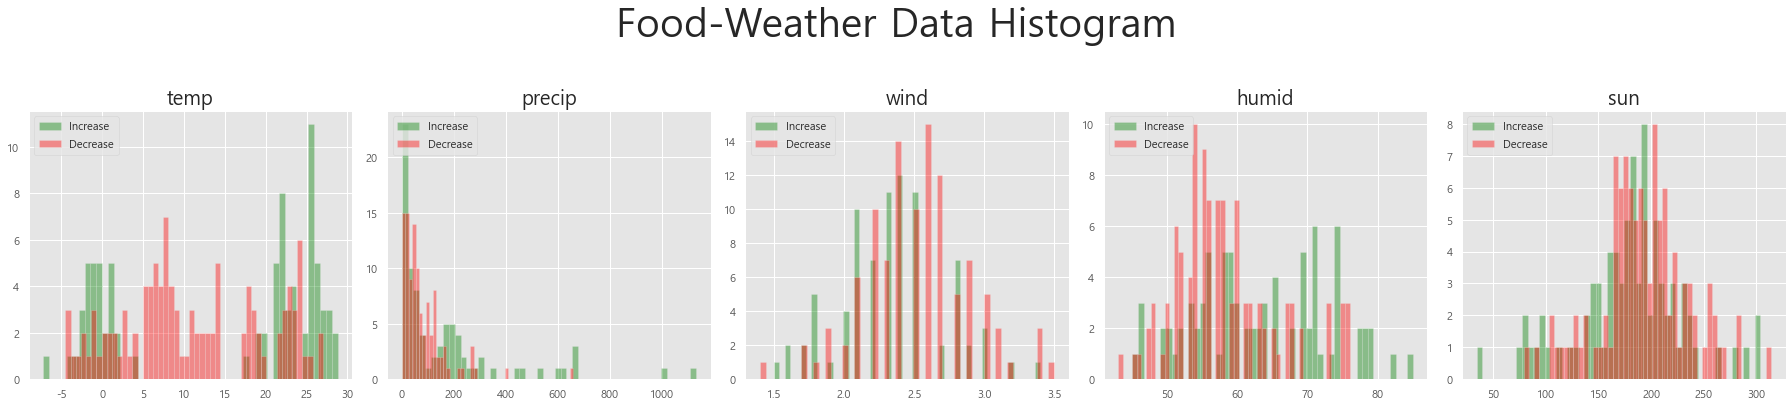

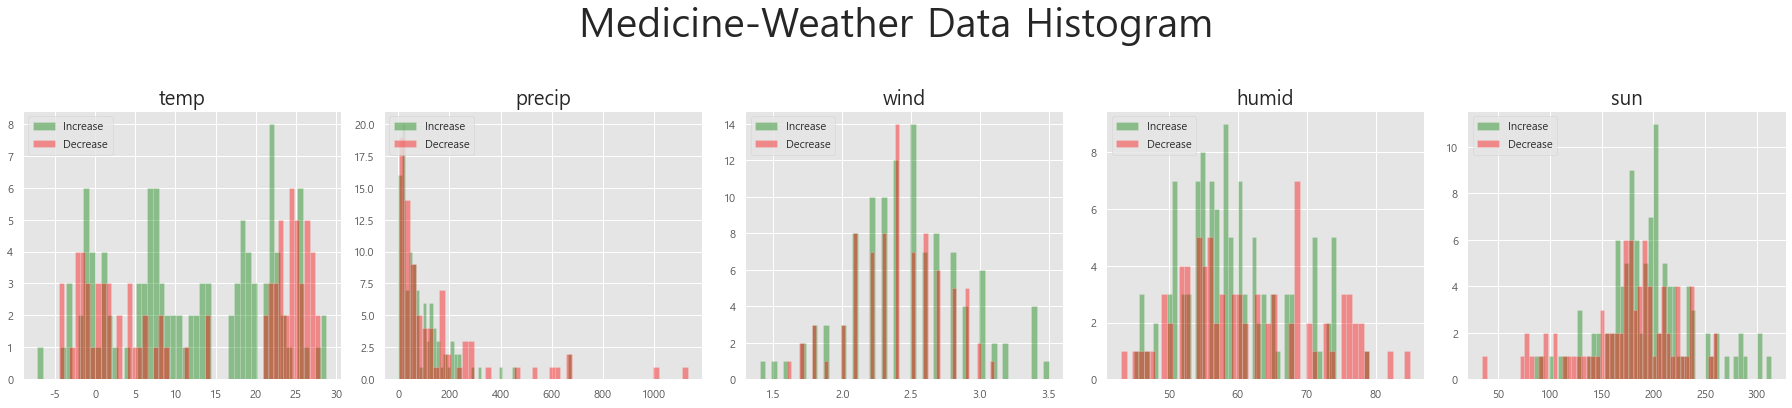

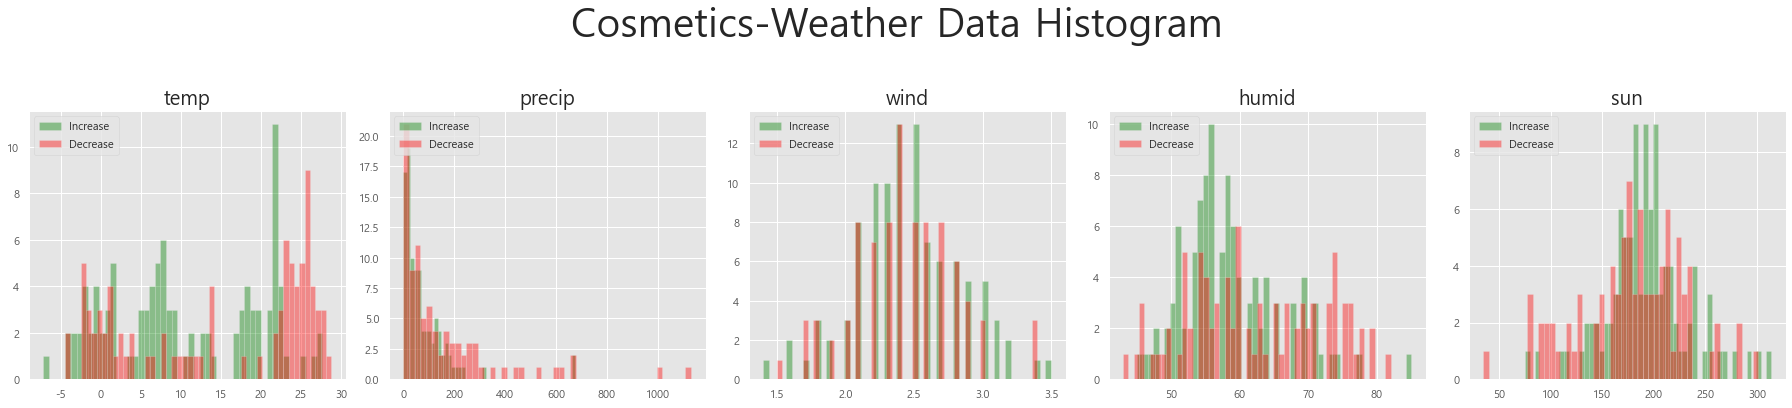

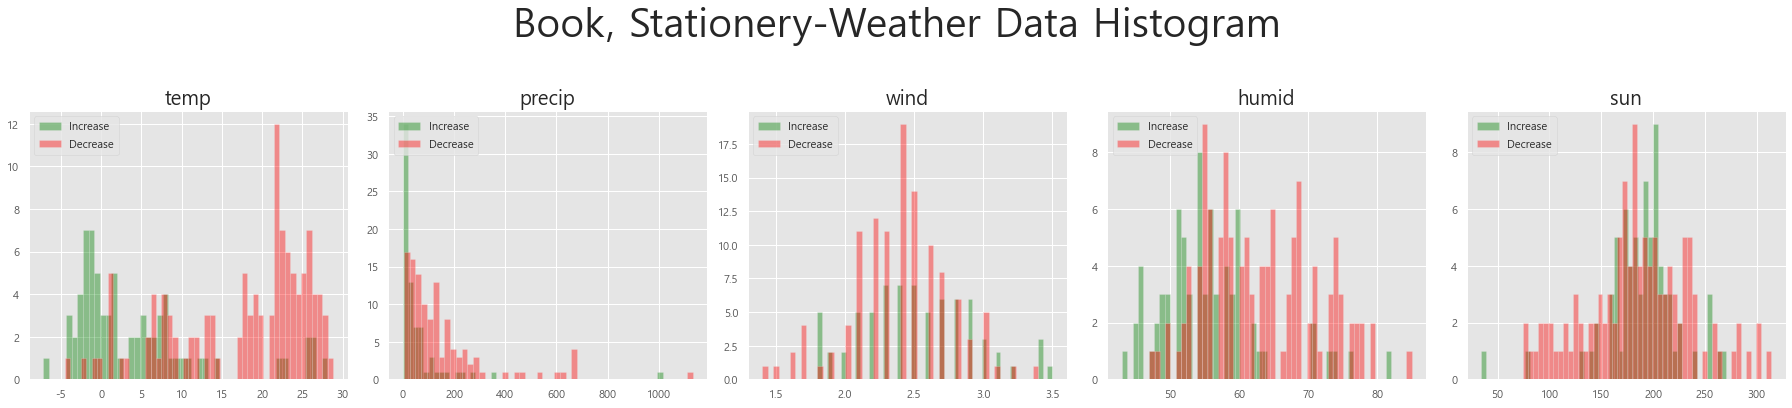

In [9]:
# 판매지수 증감여부에 따른 날씨 데이터 히스토그램
for i,p in enumerate(product_columns):       
    tmp_increase = df_dict[p].loc[df_dict[p]['sales_increase']==1][['temp','precip', 'wind', 'humid', 'sun']]
    tmp_decrease = df_dict[p].loc[df_dict[p]['sales_increase']==0][['temp','precip', 'wind', 'humid', 'sun']]
    
    cols = tmp_increase.columns
    len_col, len_row = min(len(cols), 5), len(cols)//5 + 1
    
    plt.figure(figsize=(len_col*5, len_row*5))
    plt.suptitle(f"{product_list[i]}-Weather Data Histogram", fontsize=40)
    
    j=0
    for col in tmp_increase.columns:
        j+=1
        plt.subplot(len_row,len_col,j)
        plt.title(col, fontsize=20)
        plt.hist(tmp_increase[col], color = 'green', alpha = 0.4, bins = 50, label='Increase')
        plt.hist(tmp_decrease[col], color = 'red', alpha = 0.4, bins = 50, label='Decrease')
        plt.legend(loc='upper left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt. show()

In [10]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 판매지수 증감여부에 따른 날씨 데이터 ANOVA
for i,p in enumerate(product_columns):
    print(f'상품군 :{p}\n')
    tmp_increase = df_dict[p].loc[df_dict[p]['sales_increase']==1][['temp','precip', 'wind', 'humid', 'sun']]
    tmp_decrease = df_dict[p].loc[df_dict[p]['sales_increase']==0][['temp','precip', 'wind', 'humid', 'sun']]
    
    cols = ['temp','precip', 'wind', 'humid', 'sun']
    
    for col in cols:
        print(f'변수 :{col}\n')
        model = ols(f'sales_increase ~ {col}', df_dict[p][['sales_increase']+[col]]).fit()
        display(anova_lm(model))
    print('------------------------------------\n')

상품군 :승용차

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.361927,1.361927,5.585594,0.018897
Residual,243.0,59.250318,0.243828,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.032431,0.032431,0.130087,0.718655
Residual,243.0,60.579814,0.249300,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.101027,0.101027,0.405701,0.524759
Residual,243.0,60.511218,0.249017,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.156451,0.156451,0.628849,0.428551
Residual,243.0,60.455794,0.248789,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.403275,0.403275,1.627595,0.203254
Residual,243.0,60.208970,0.247774,NaN,NaN


------------------------------------

상품군 :가전제품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,7.364020,7.364020,34.511733,1.892204e-08
Residual,188.0,40.114928,0.213377,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,5.077600,5.077600,22.513172,0.000004
Residual,188.0,42.401347,0.225539,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,1.957791,1.957791,8.085573,0.004956
Residual,188.0,45.521157,0.242134,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,12.093597,12.093597,64.252469,1.130091e-13
Residual,188.0,35.385351,0.188220,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,2.402891,2.402891,10.021806,0.001805
Residual,188.0,45.076057,0.239766,NaN,NaN


------------------------------------

상품군 :가구

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,6.326409,6.326409,28.919869,2.222095e-07
Residual,188.0,41.126222,0.218757,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,3.243554,3.243554,13.79328,0.000269
Residual,188.0,44.209078,0.235155,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,3.114137,3.114137,13.204275,0.00036
Residual,188.0,44.338495,0.235843,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,7.019210,7.019210,32.636654,4.286530e-08
Residual,188.0,40.433421,0.215071,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,1.513656,1.513656,6.194464,0.013684
Residual,188.0,45.938976,0.244356,NaN,NaN


------------------------------------

상품군 :의복

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,5.378679,5.378679,24.018652,0.000002
Residual,188.0,42.100268,0.223938,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,4.753109,4.753109,20.91438,0.000009
Residual,188.0,42.725839,0.227265,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.897637,0.897637,3.62282,0.05852
Residual,188.0,46.581311,0.247773,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,6.212683,6.212683,28.303615,2.928772e-07
Residual,188.0,41.266264,0.219501,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,1.950683,1.950683,8.054961,0.005036
Residual,188.0,45.528264,0.242172,NaN,NaN


------------------------------------

상품군 :가방

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.026772,1.026772,4.173439,0.043038
Residual,133.0,32.721376,0.246025,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,0.140259,0.140259,0.555061,0.457571
Residual,133.0,33.607889,0.252691,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.295246,0.295246,1.173821,0.280578
Residual,133.0,33.452902,0.251526,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,0.384282,0.384282,1.531881,0.218011
Residual,133.0,33.363866,0.250856,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.053326,0.053326,0.210488,0.647134
Residual,133.0,33.694822,0.253345,NaN,NaN


------------------------------------

상품군 :음식료품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,1.396537,1.396537,5.806807,0.016928
Residual,188.0,45.213989,0.240500,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,2.910942,2.910942,12.523166,0.000506
Residual,188.0,43.699584,0.232445,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,2.749916,2.749916,11.786982,0.000734
Residual,188.0,43.860610,0.233301,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,3.614327,3.614327,15.80357,0.0001
Residual,188.0,42.996199,0.228703,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.890423,0.890423,3.661397,0.057206
Residual,188.0,45.720104,0.243192,NaN,NaN


------------------------------------

상품군 :의약품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,0.149040,0.14904,0.604921,0.437684
Residual,188.0,46.319381,0.24638,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,1.248657,1.248657,5.191258,0.023825
Residual,188.0,45.219764,0.240531,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.355599,0.355599,1.449763,0.23008
Residual,188.0,46.112822,0.245281,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,1.123074,1.123074,4.656219,0.03221
Residual,188.0,45.345347,0.241199,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,2.486348,2.486348,10.627816,0.001322
Residual,188.0,43.982073,0.233947,NaN,NaN


------------------------------------

상품군 :화장품

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,2.053288,2.053288,8.542336,0.003896
Residual,188.0,45.188818,0.240366,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,2.642993,2.642993,11.141091,0.001018
Residual,188.0,44.599112,0.237229,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,0.056161,0.056161,0.223759,0.63674
Residual,188.0,47.185944,0.250989,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,2.295029,2.295029,9.59941,0.002245
Residual,188.0,44.947076,0.239080,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.963400,0.963400,3.913663,0.049356
Residual,188.0,46.278705,0.246163,NaN,NaN


------------------------------------

상품군 :서적, 문구

변수 :temp



,df,sum_sq,mean_sq,F,PR(>F)
temp,1.0,16.909635,16.909635,113.362046,5.121479e-21
Residual,188.0,28.042996,0.149165,NaN,NaN


변수 :precip



,df,sum_sq,mean_sq,F,PR(>F)
precip,1.0,3.158155,3.158155,14.20602,0.000219
Residual,188.0,41.794476,0.222311,NaN,NaN


변수 :wind



,df,sum_sq,mean_sq,F,PR(>F)
wind,1.0,1.260672,1.260672,5.424484,0.020919
Residual,188.0,43.691960,0.232404,NaN,NaN


변수 :humid



,df,sum_sq,mean_sq,F,PR(>F)
humid,1.0,8.168612,8.168612,41.749079,8.666016e-10
Residual,188.0,36.784020,0.195660,NaN,NaN


변수 :sun



,df,sum_sq,mean_sq,F,PR(>F)
sun,1.0,0.130710,0.130710,0.548249,0.459958
Residual,188.0,44.821921,0.238414,NaN,NaN


------------------------------------



In [11]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx
        
# 함수 사용해서 이상치 값 삭제
for i,p in enumerate(product_columns):
    for c in list(df_dict[p].iloc[:,1:-2].columns):
        outlier_idx = get_outlier(df=df_dict[p].iloc[:,1:-2].apply(pd.to_numeric), column = c, weight=1.5)
        df_dict[p].drop(outlier_idx, axis=0, inplace=True)
           
    print(f'상품군 {p}의 데이터 크기 : {df_dict[p].shape}')

상품군 승용차의 데이터 크기 : (215, 8)
상품군 가전제품의 데이터 크기 : (161, 8)
상품군 가구의 데이터 크기 : (161, 8)
상품군 의복의 데이터 크기 : (161, 8)
상품군 가방의 데이터 크기 : (116, 8)
상품군 음식료품의 데이터 크기 : (161, 8)
상품군 의약품의 데이터 크기 : (161, 8)
상품군 화장품의 데이터 크기 : (161, 8)
상품군 서적, 문구의 데이터 크기 : (161, 8)


- **HeatMap 분석**

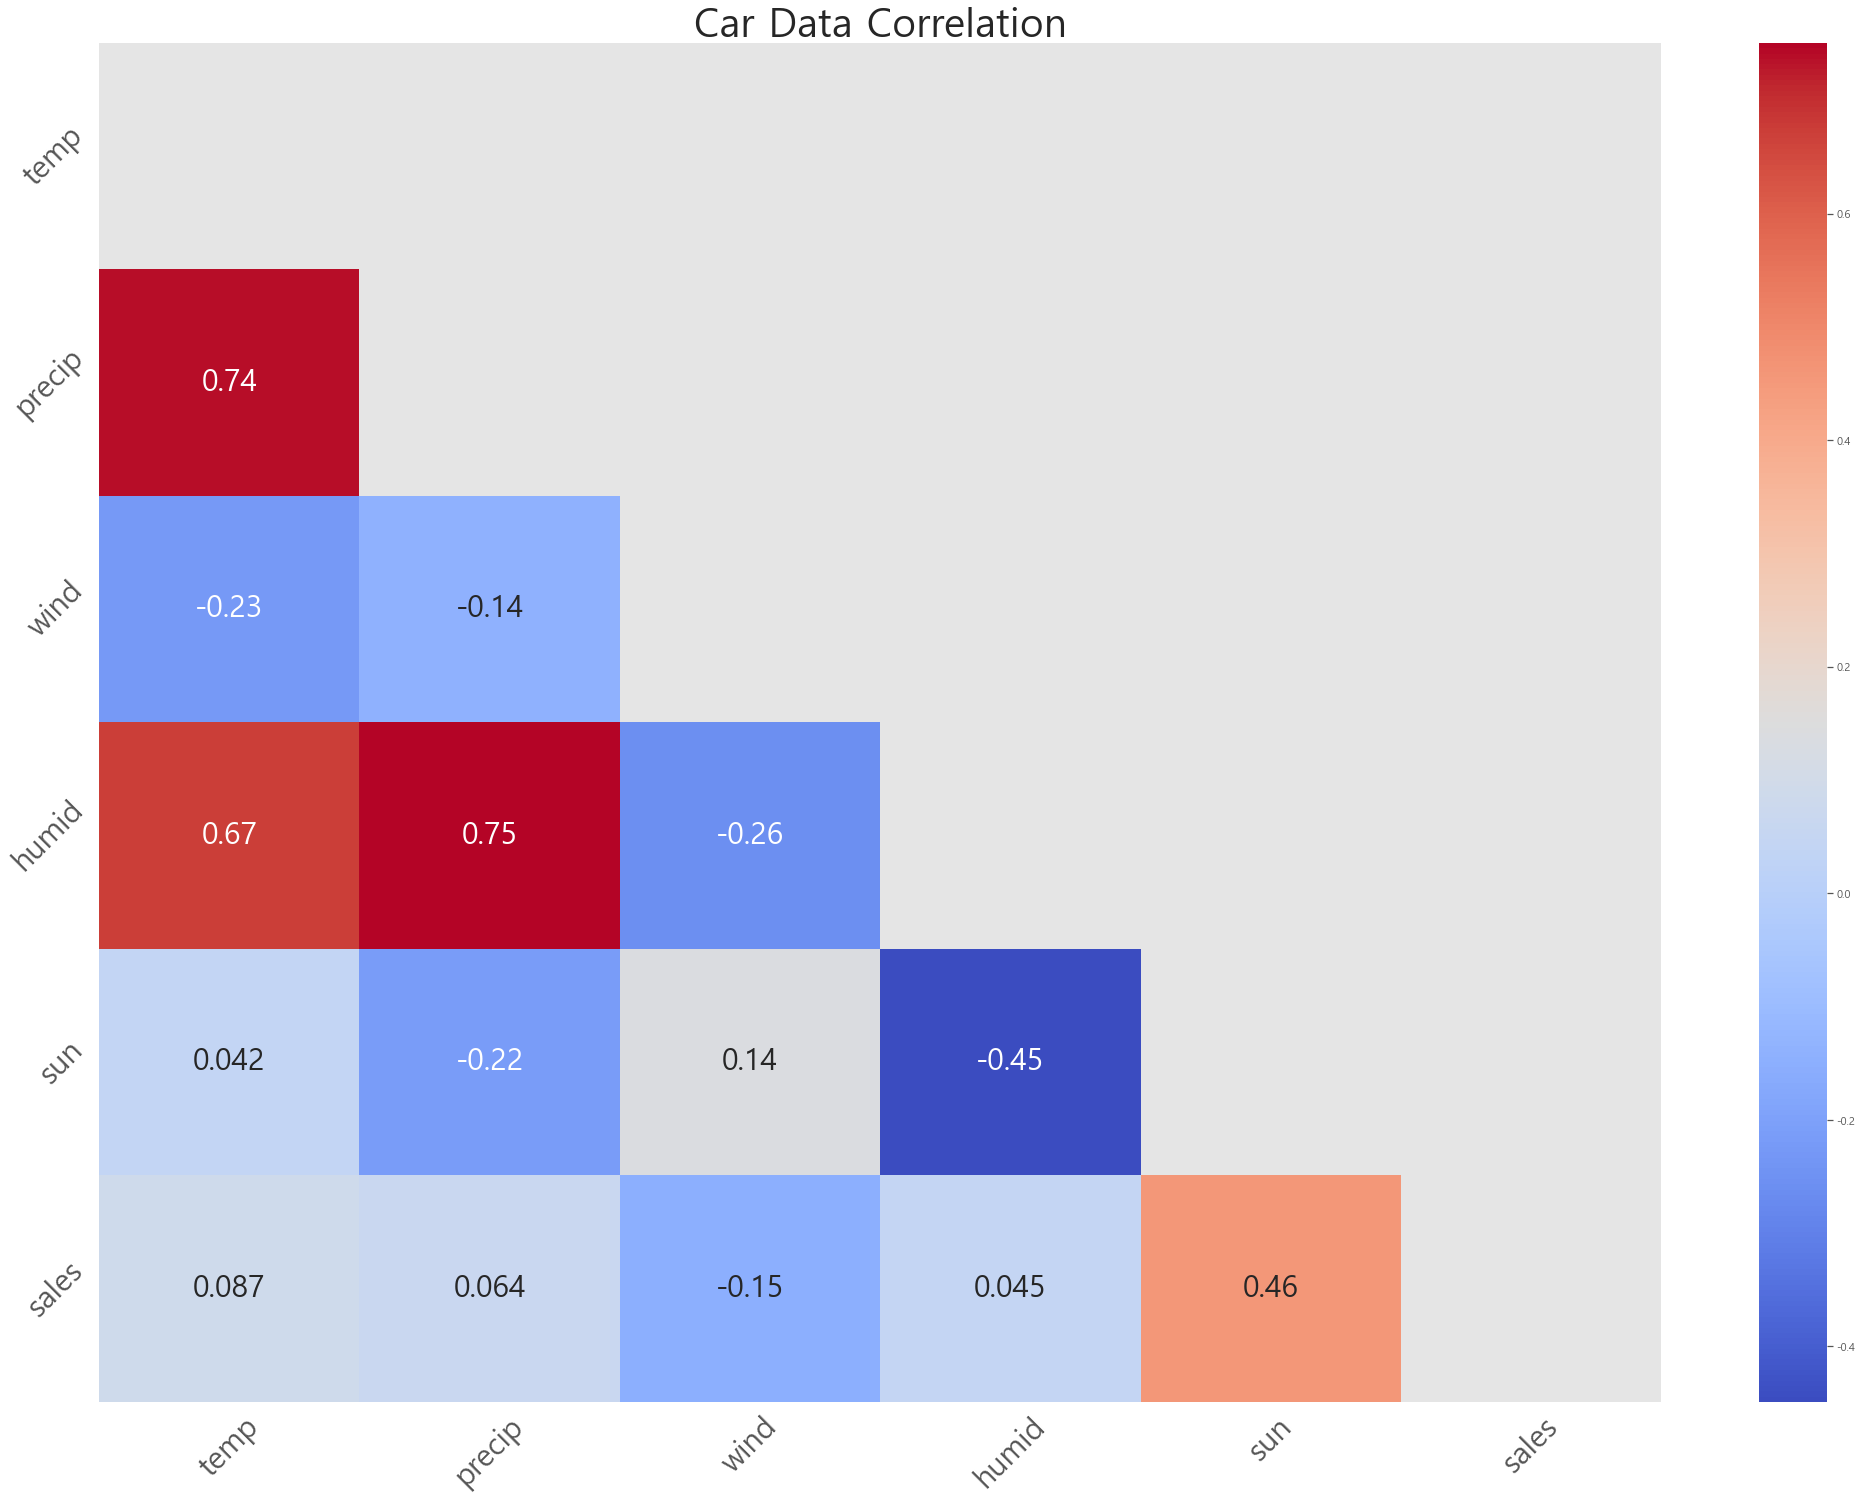

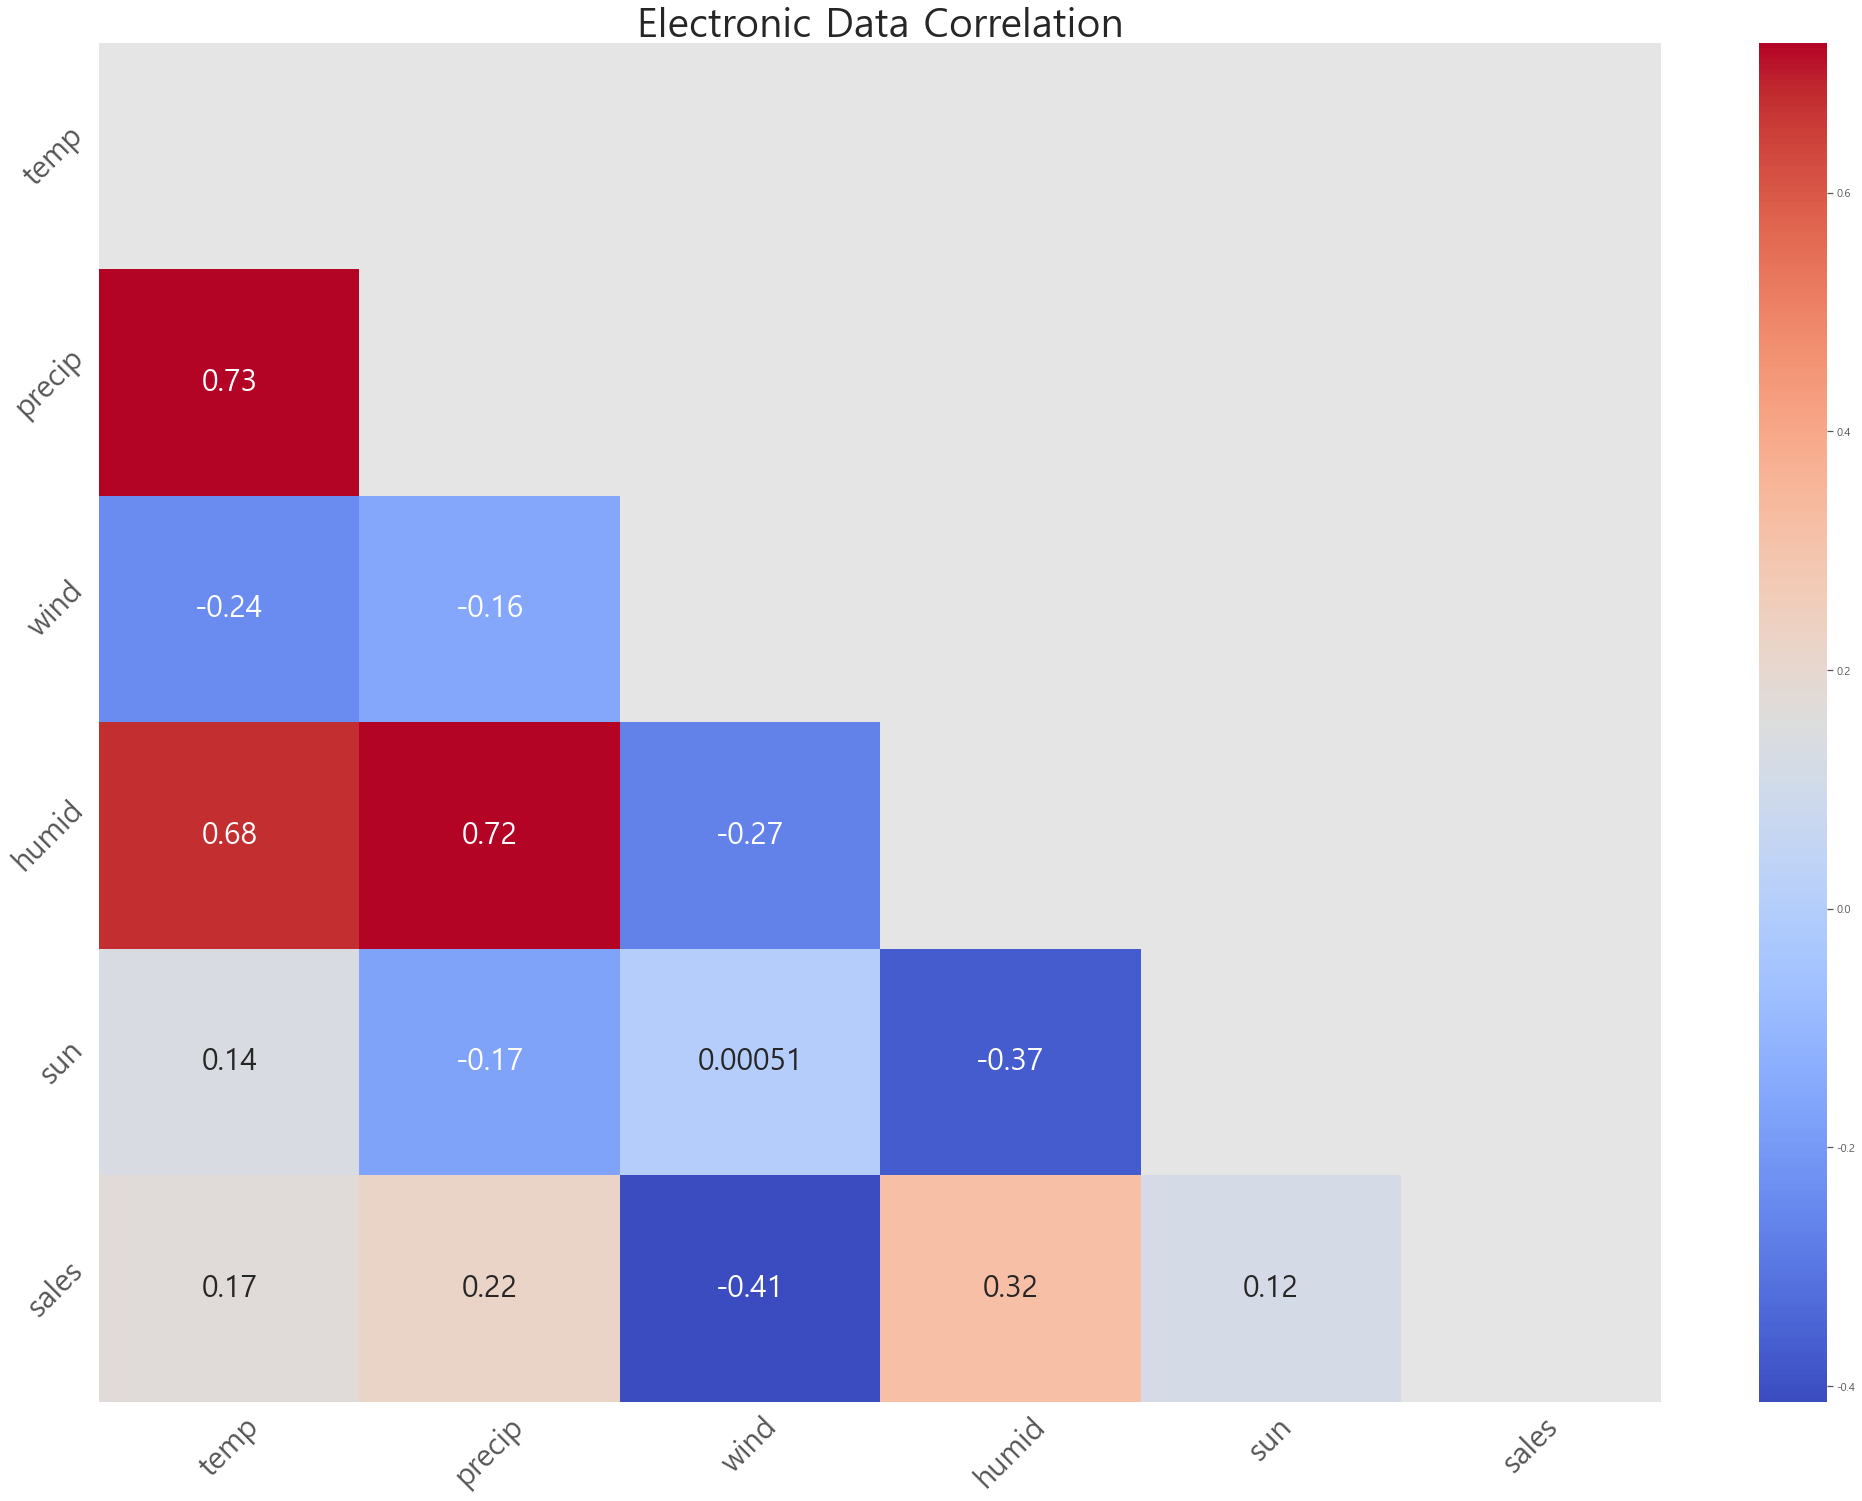

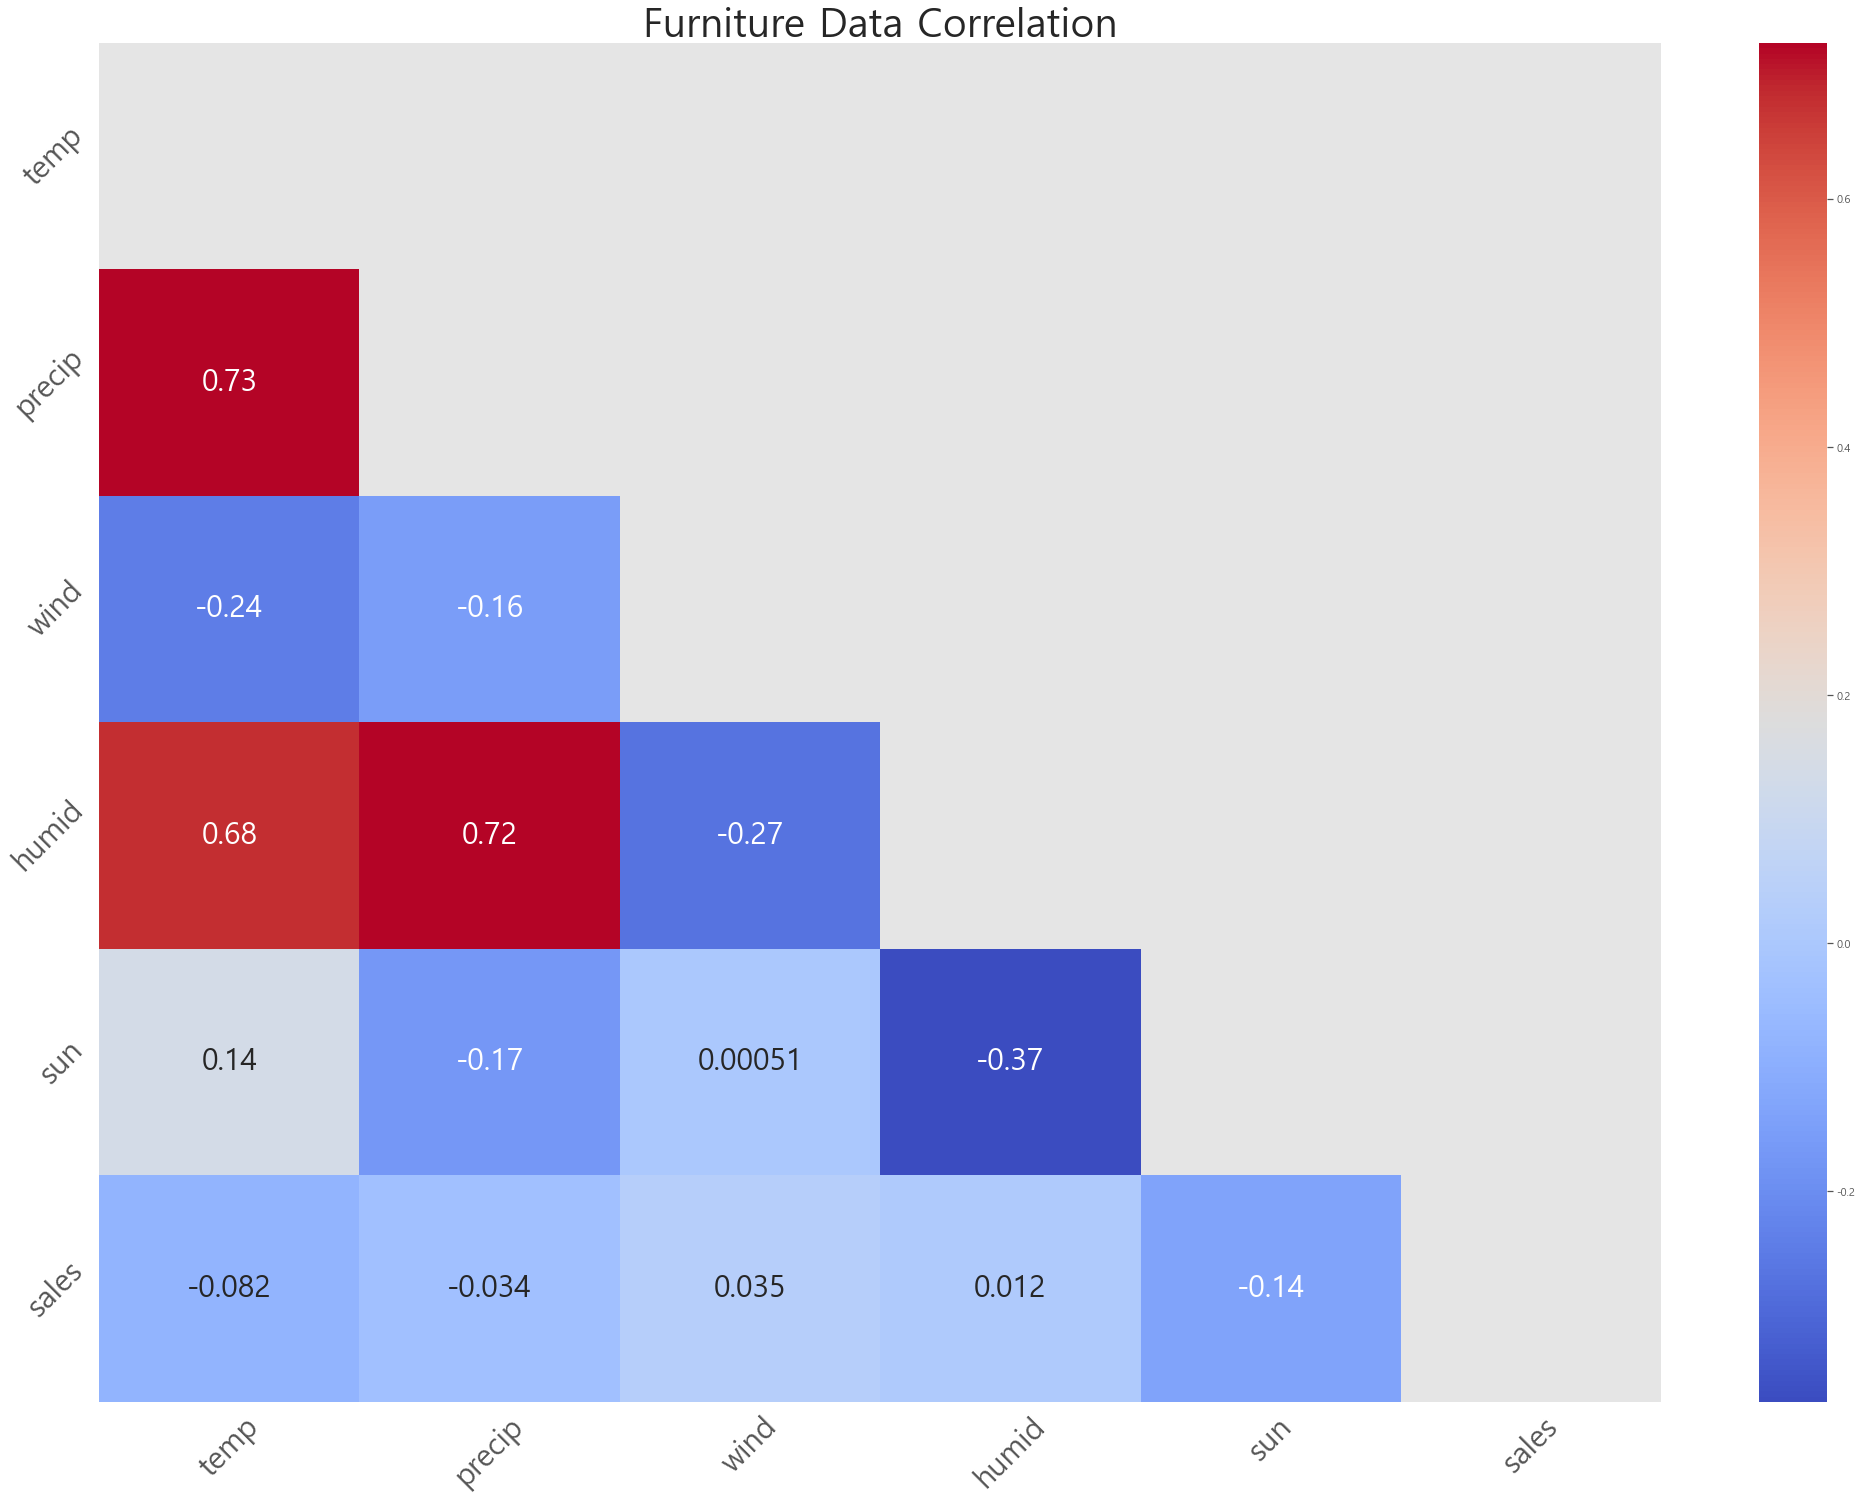

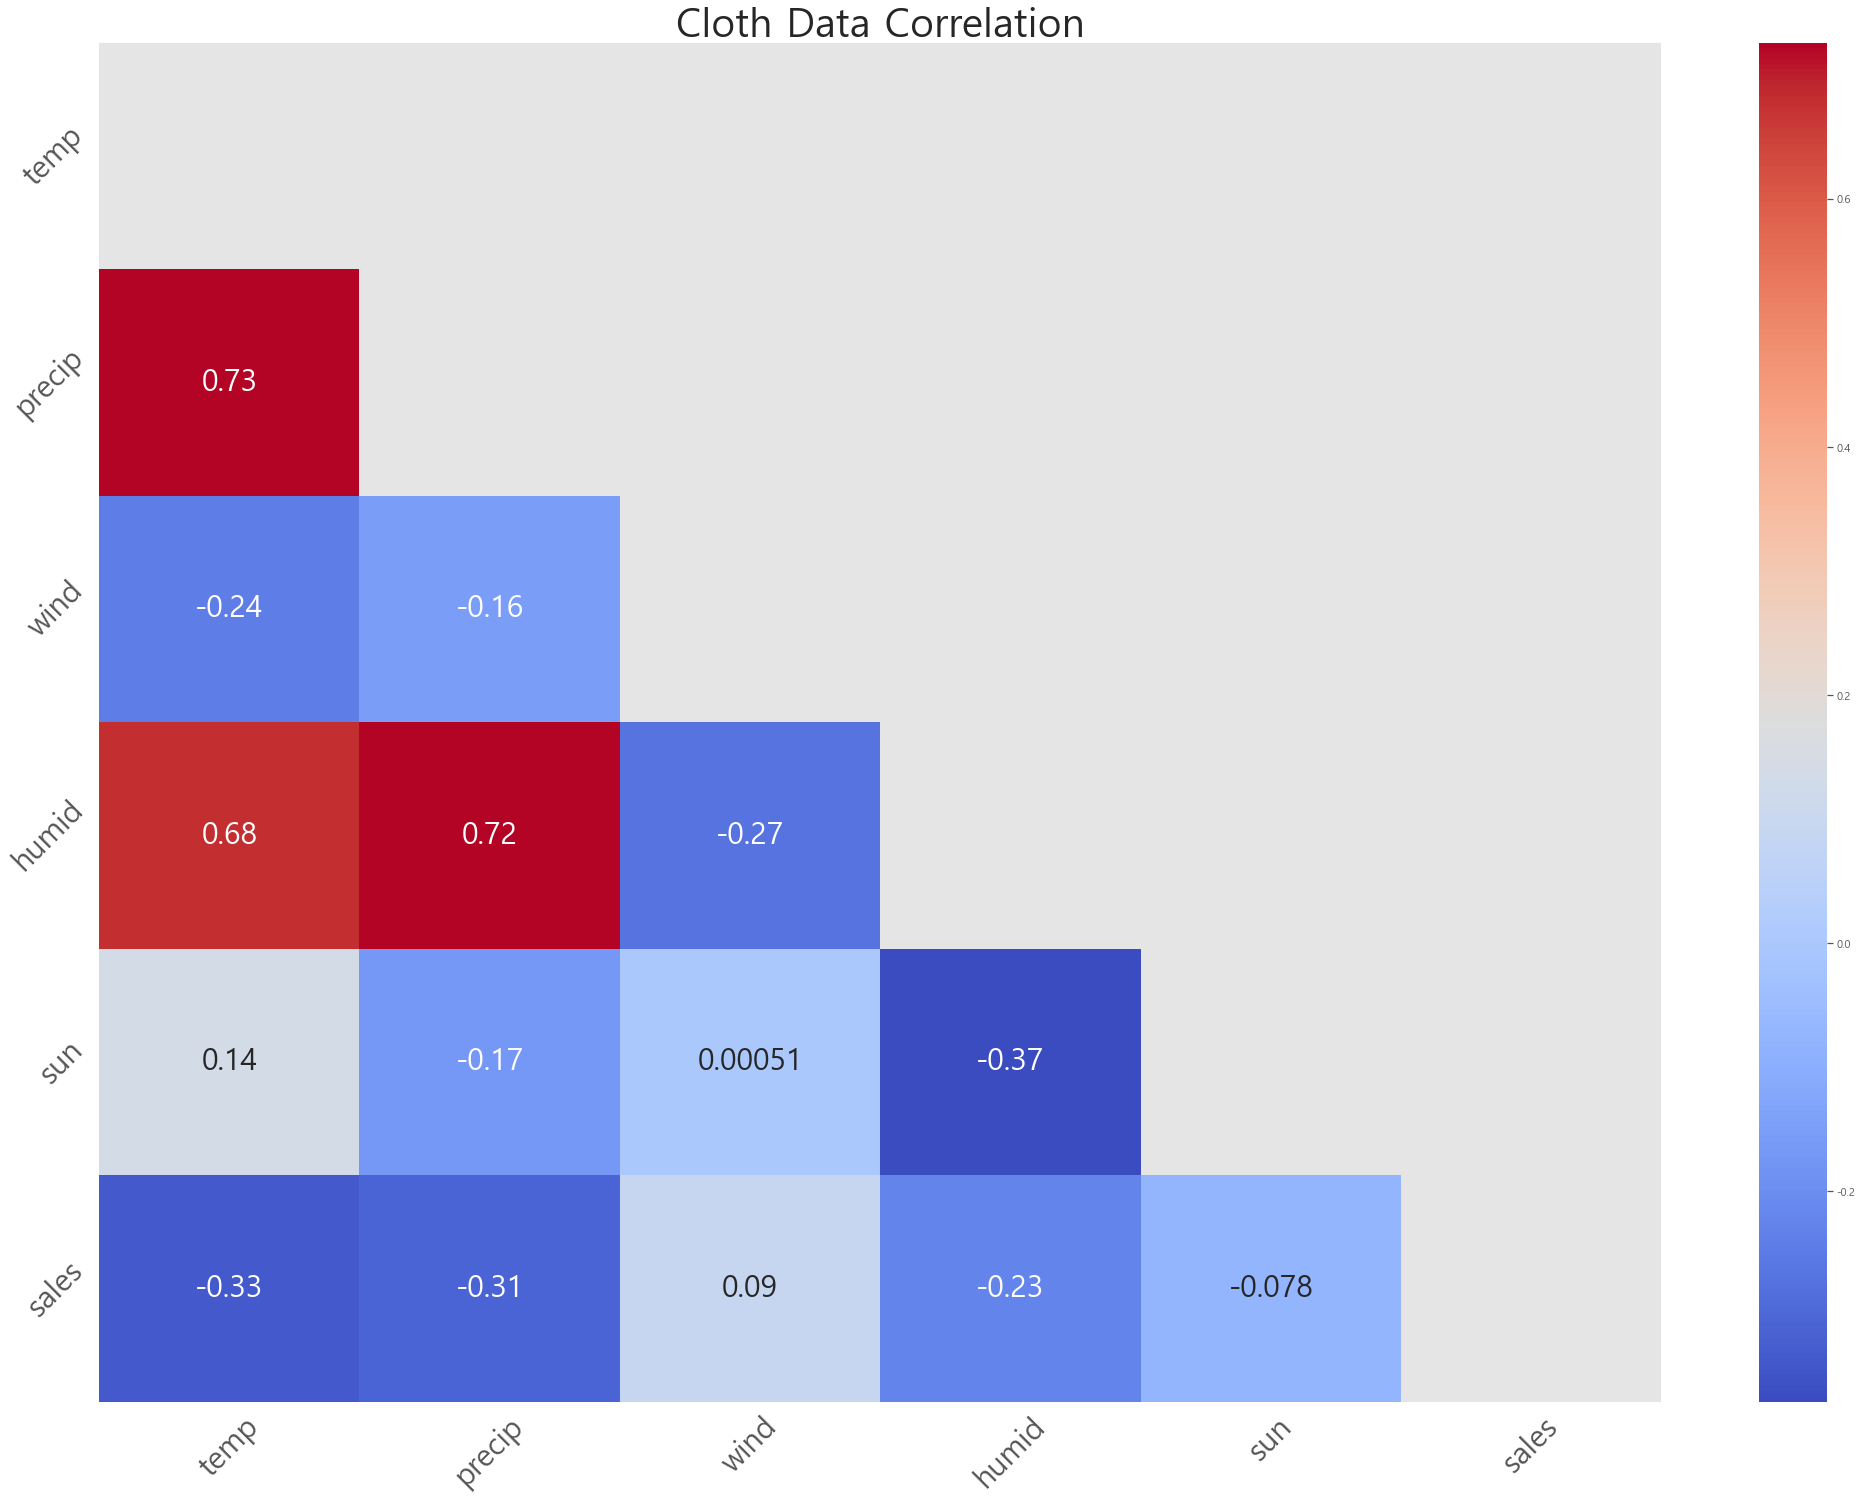

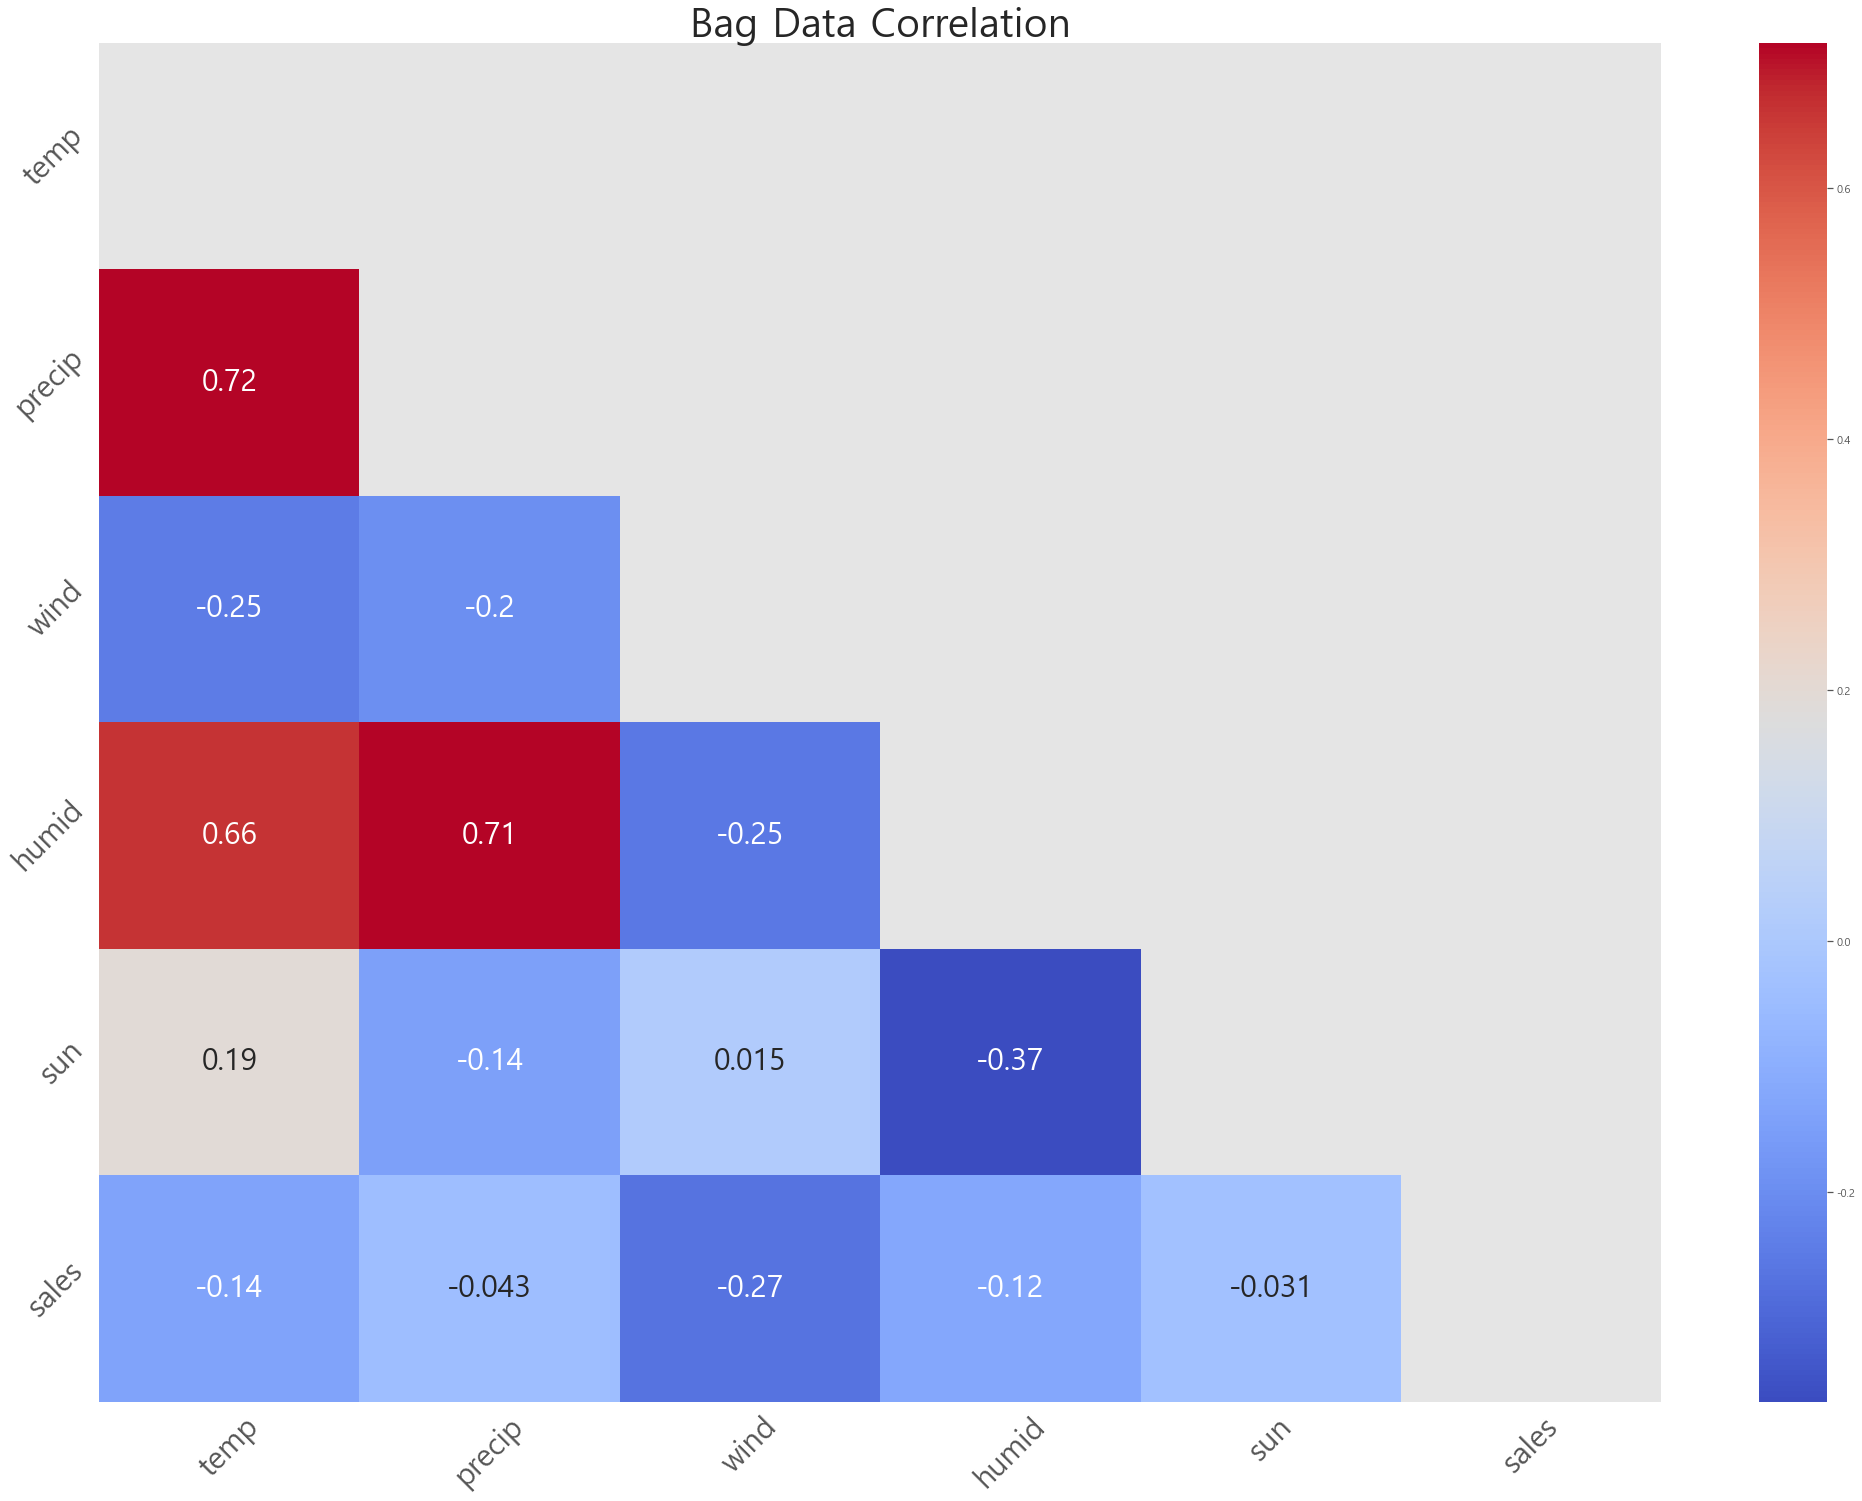

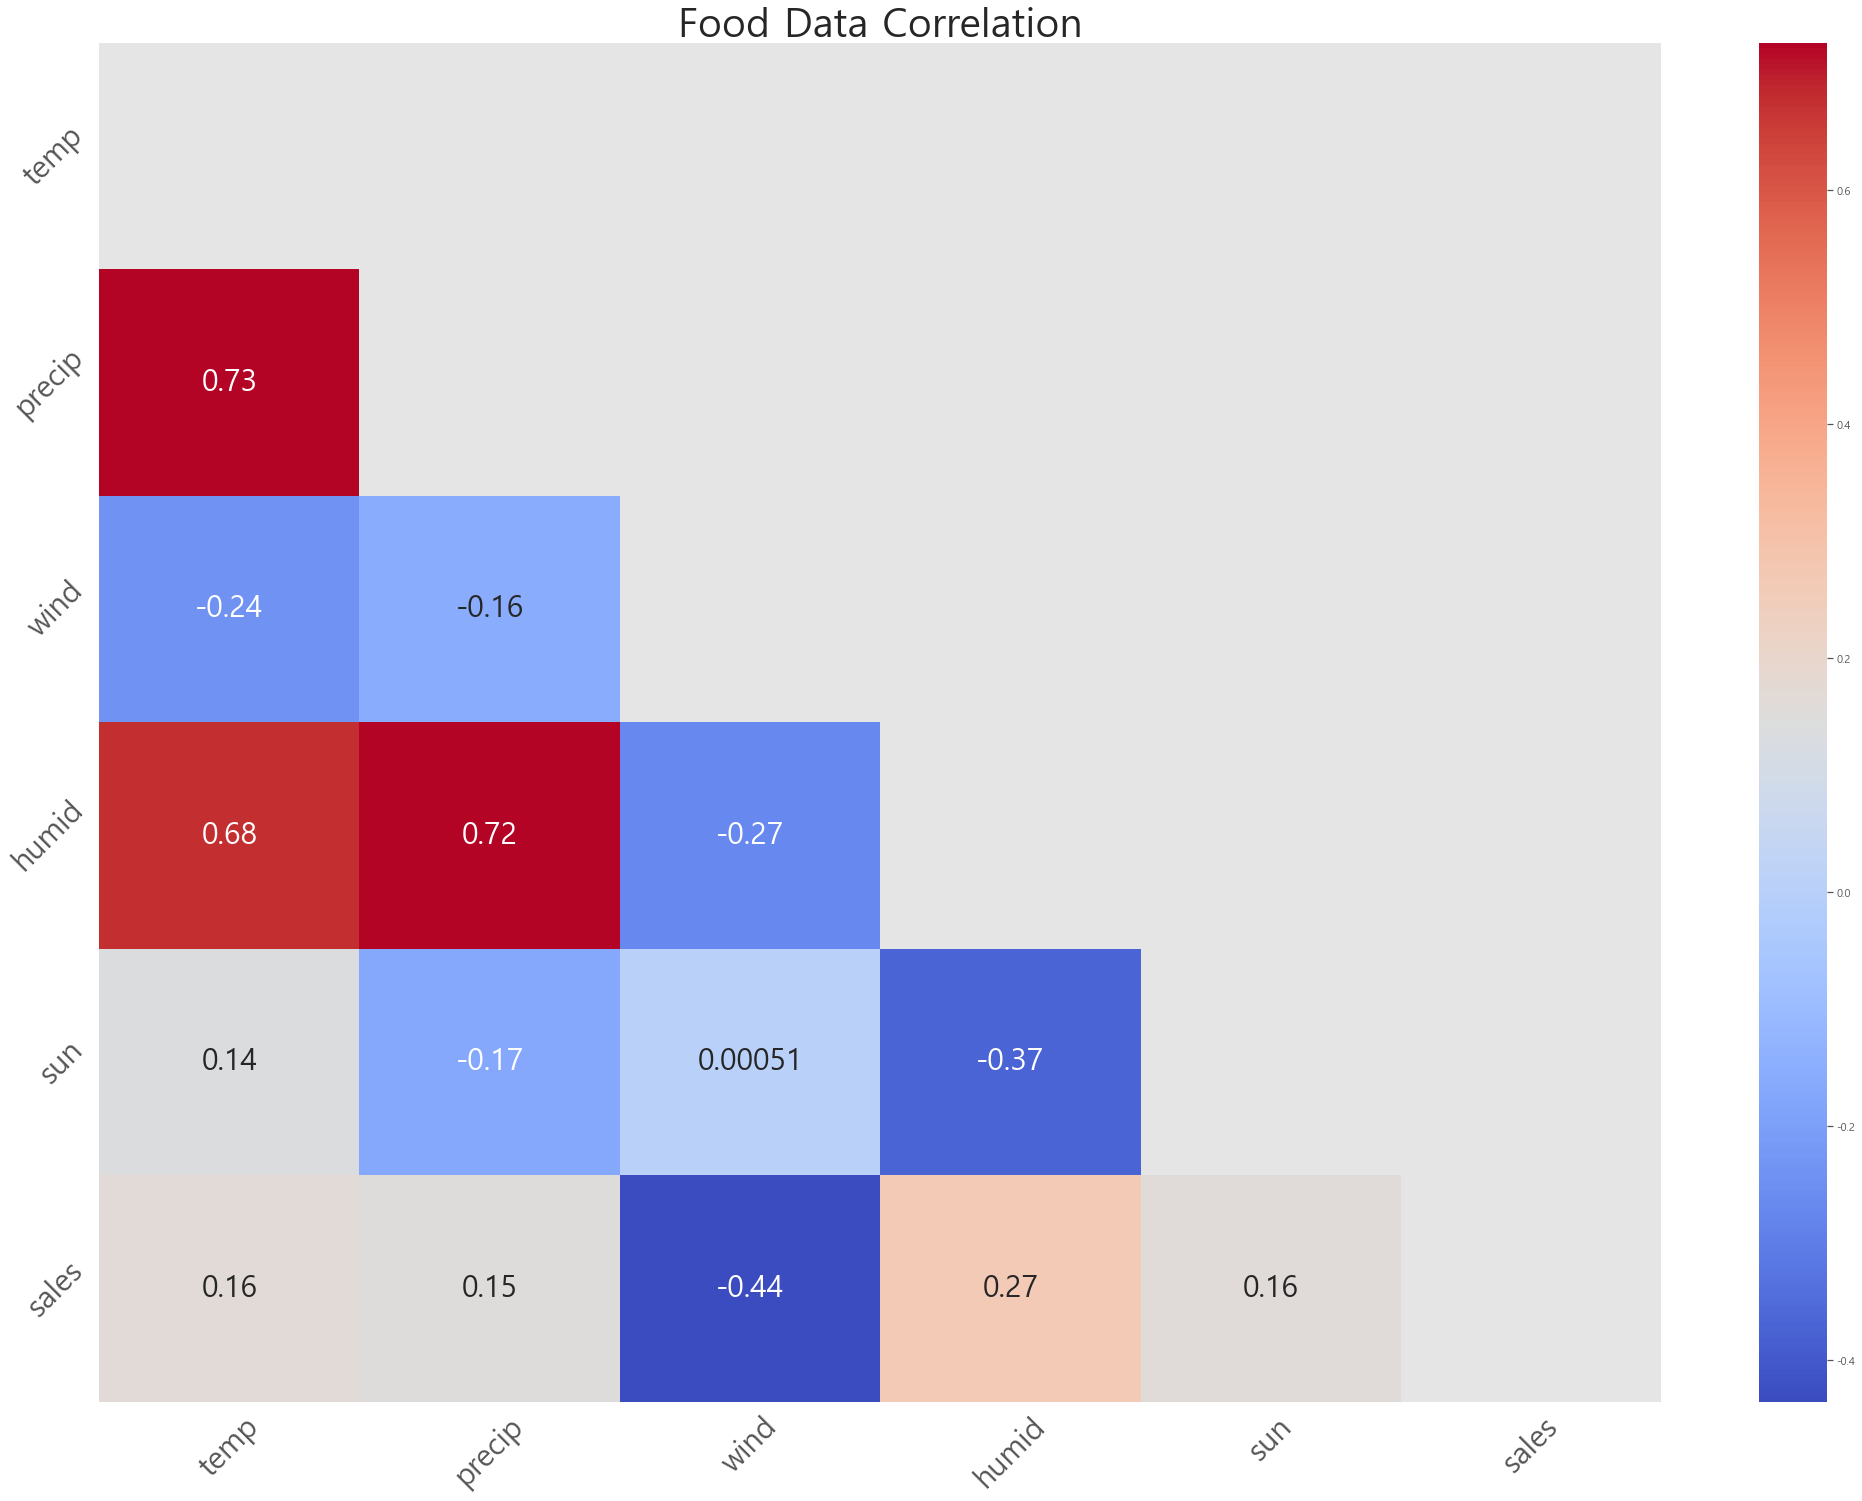

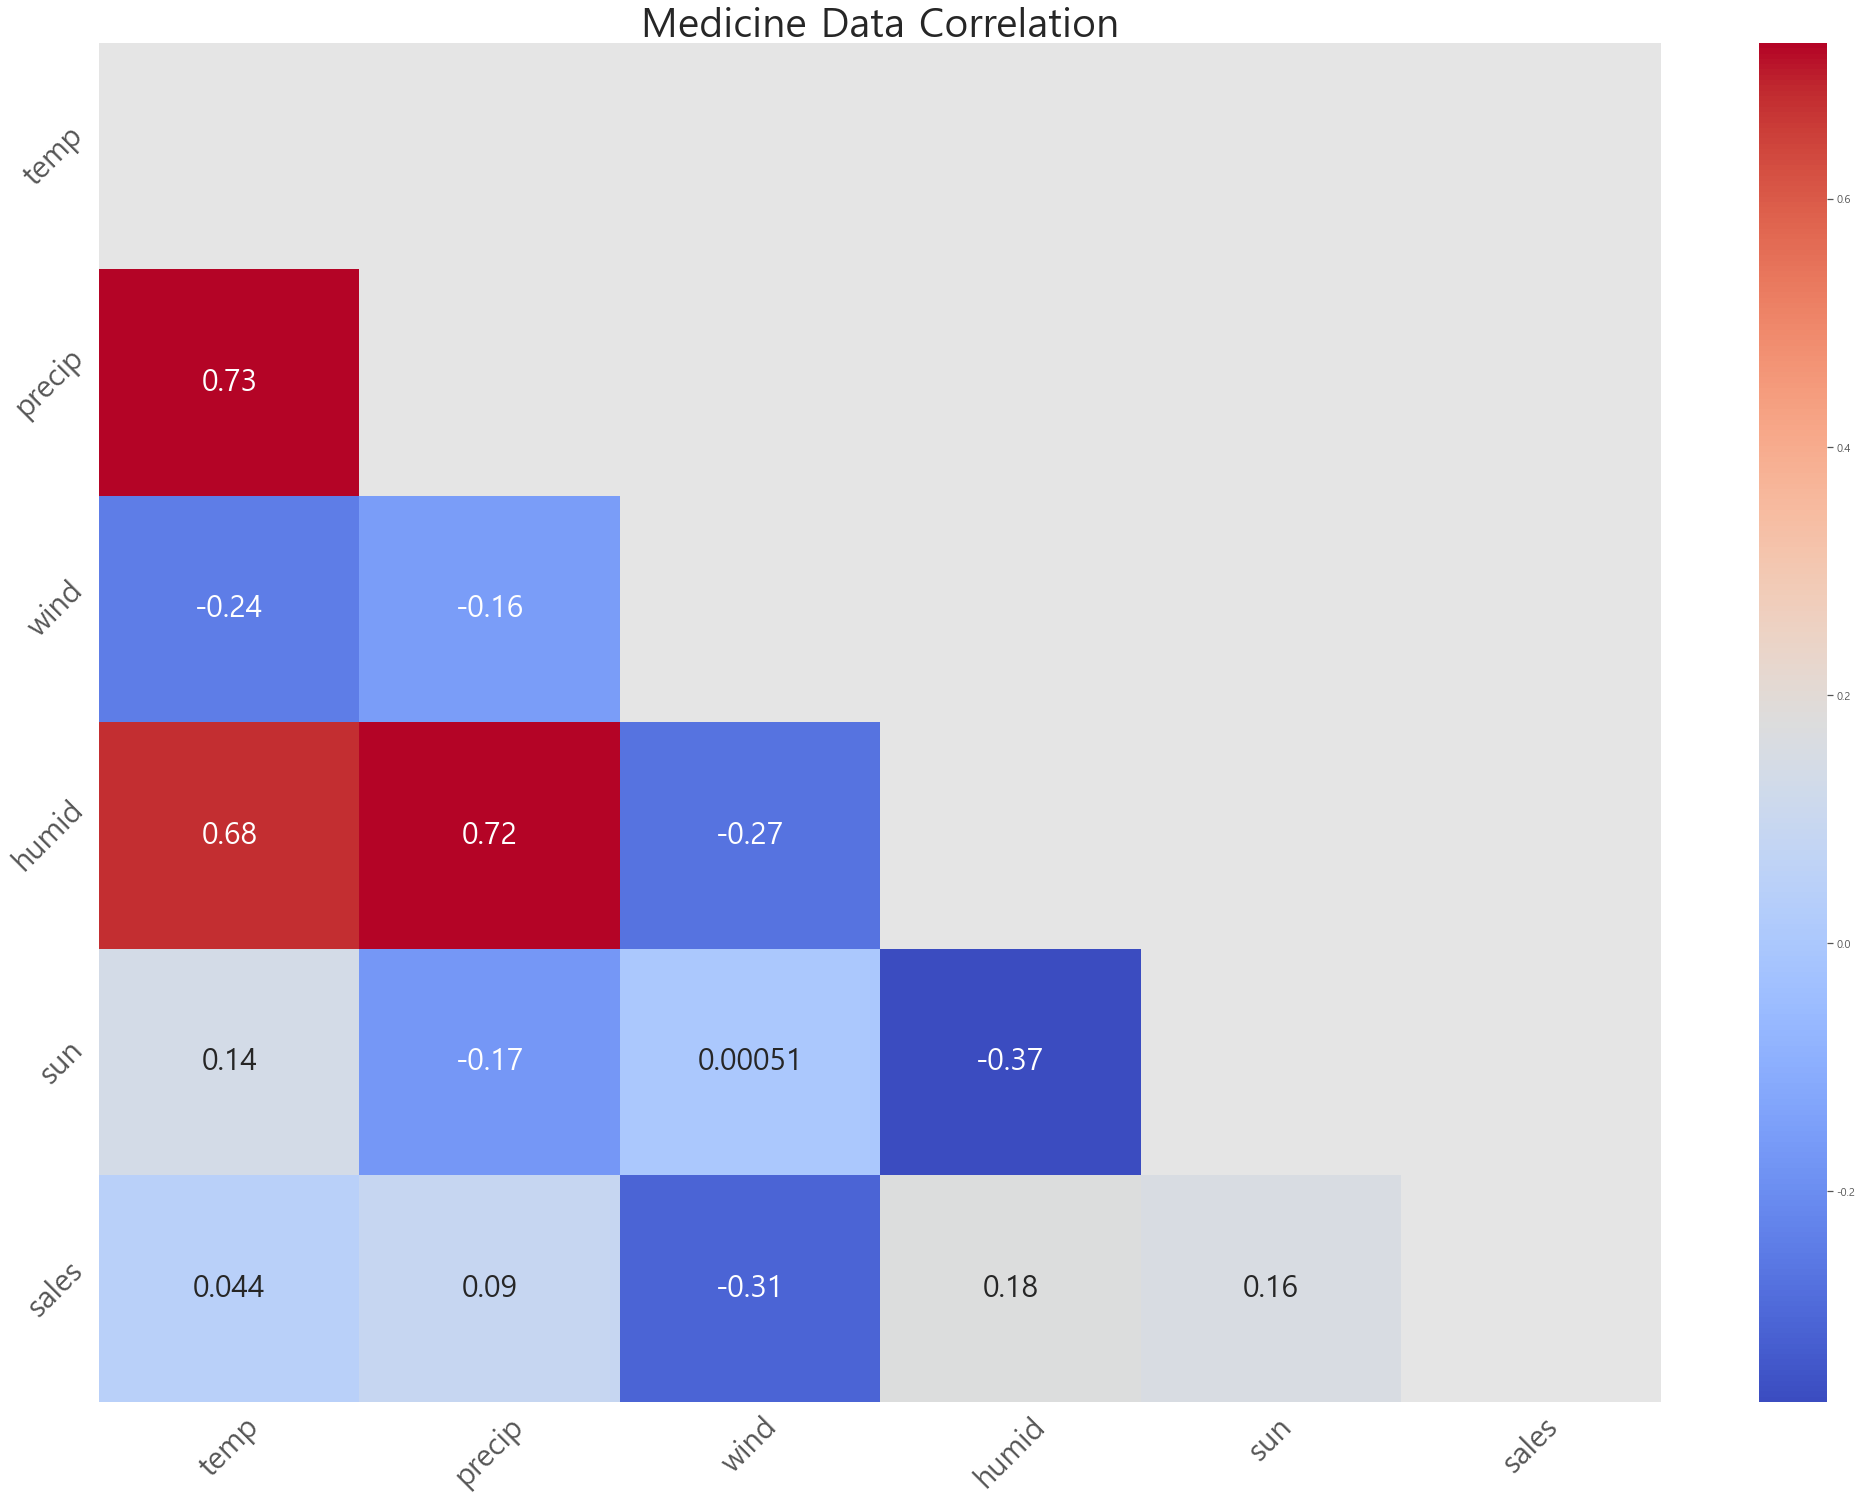

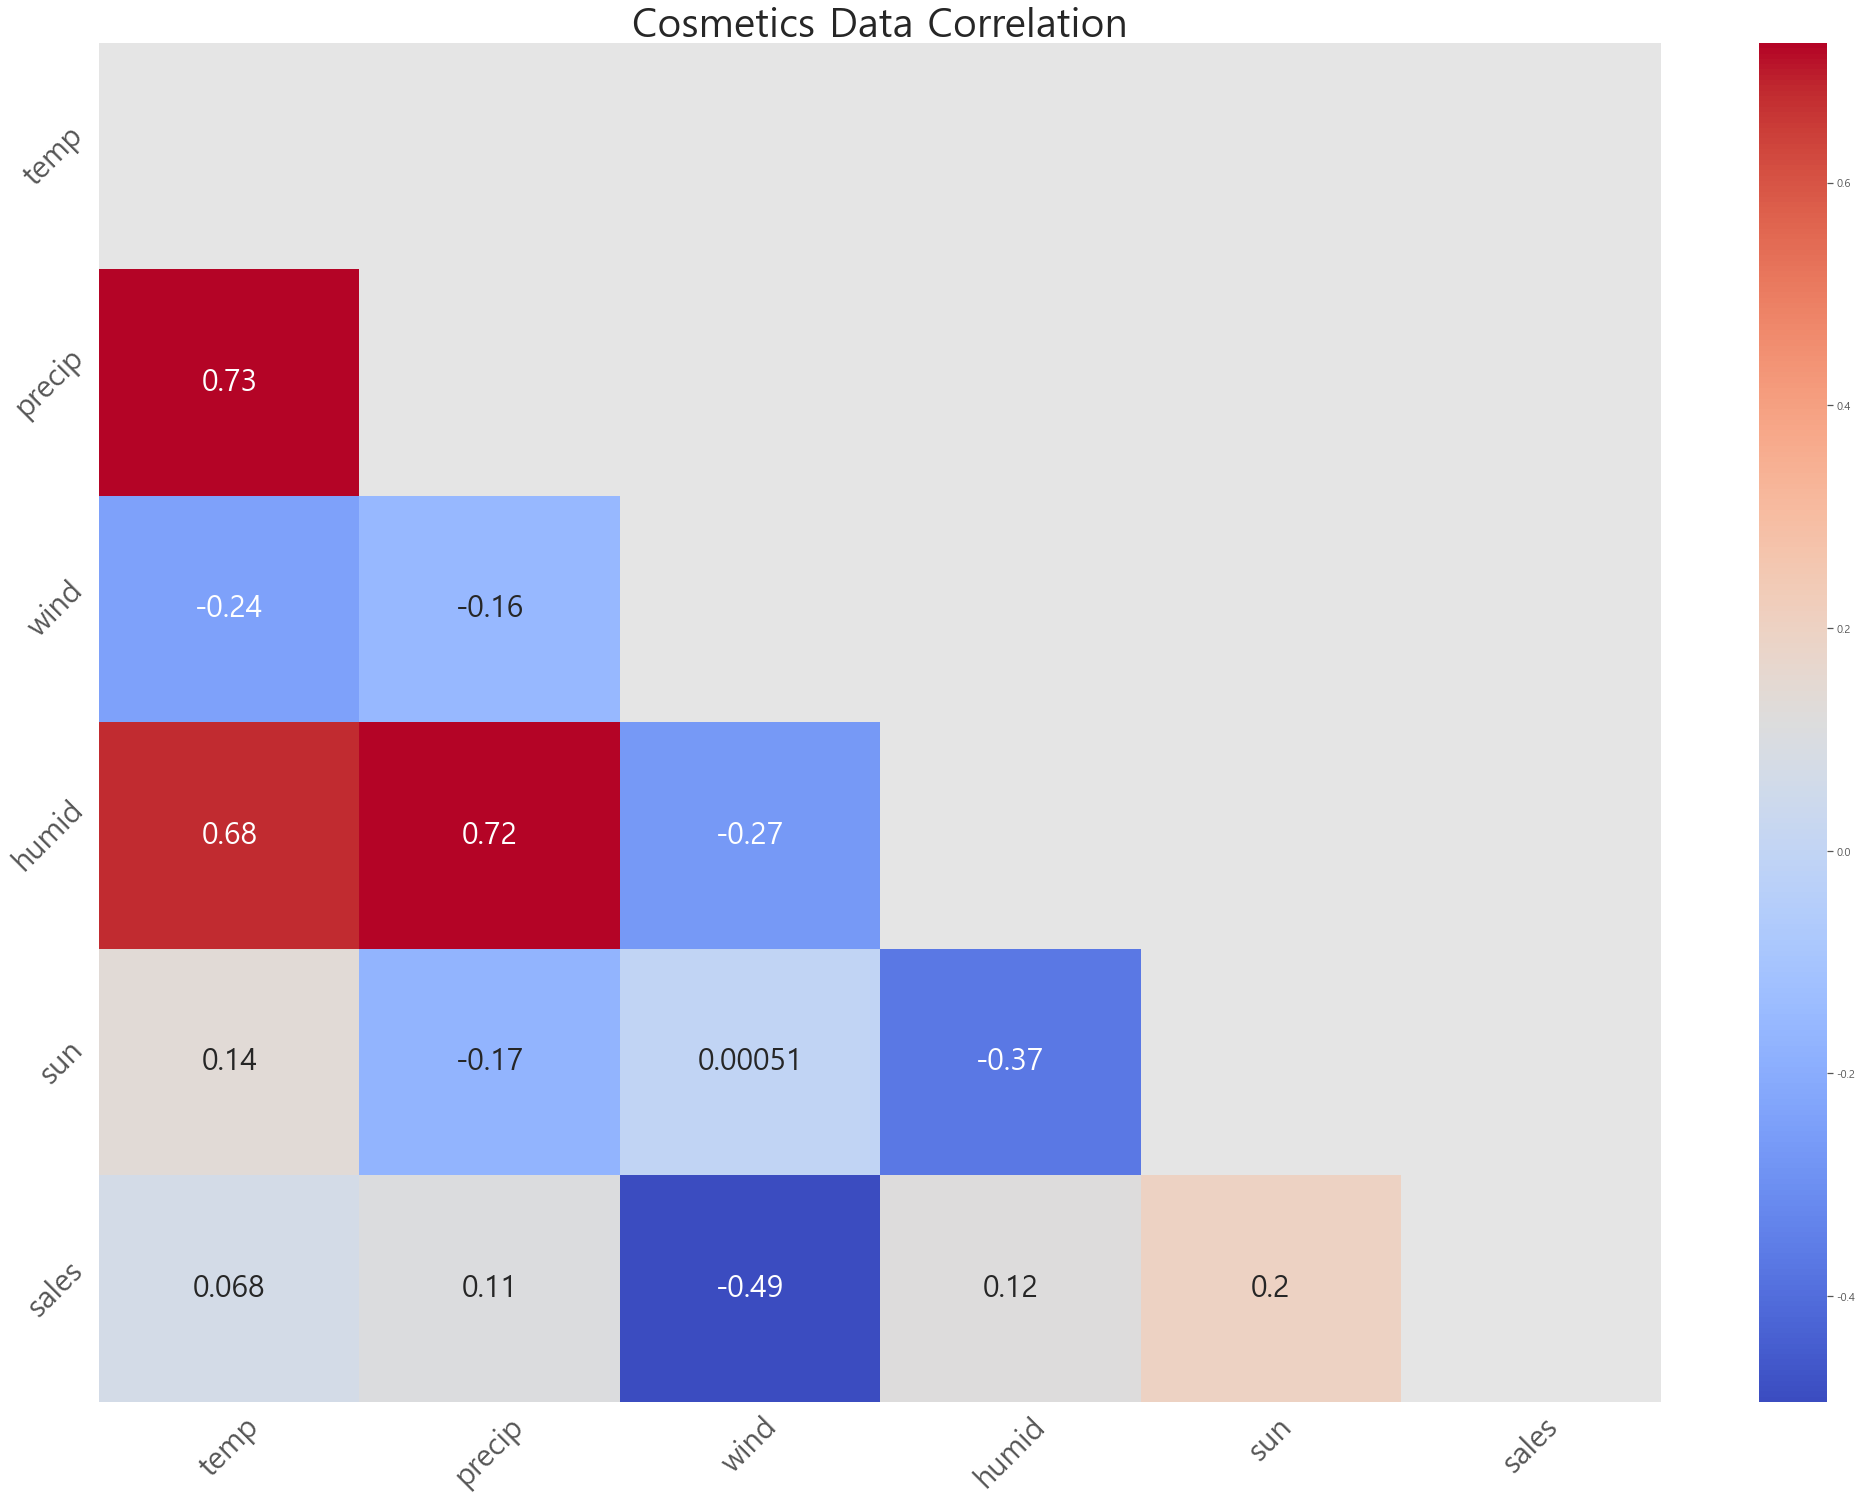

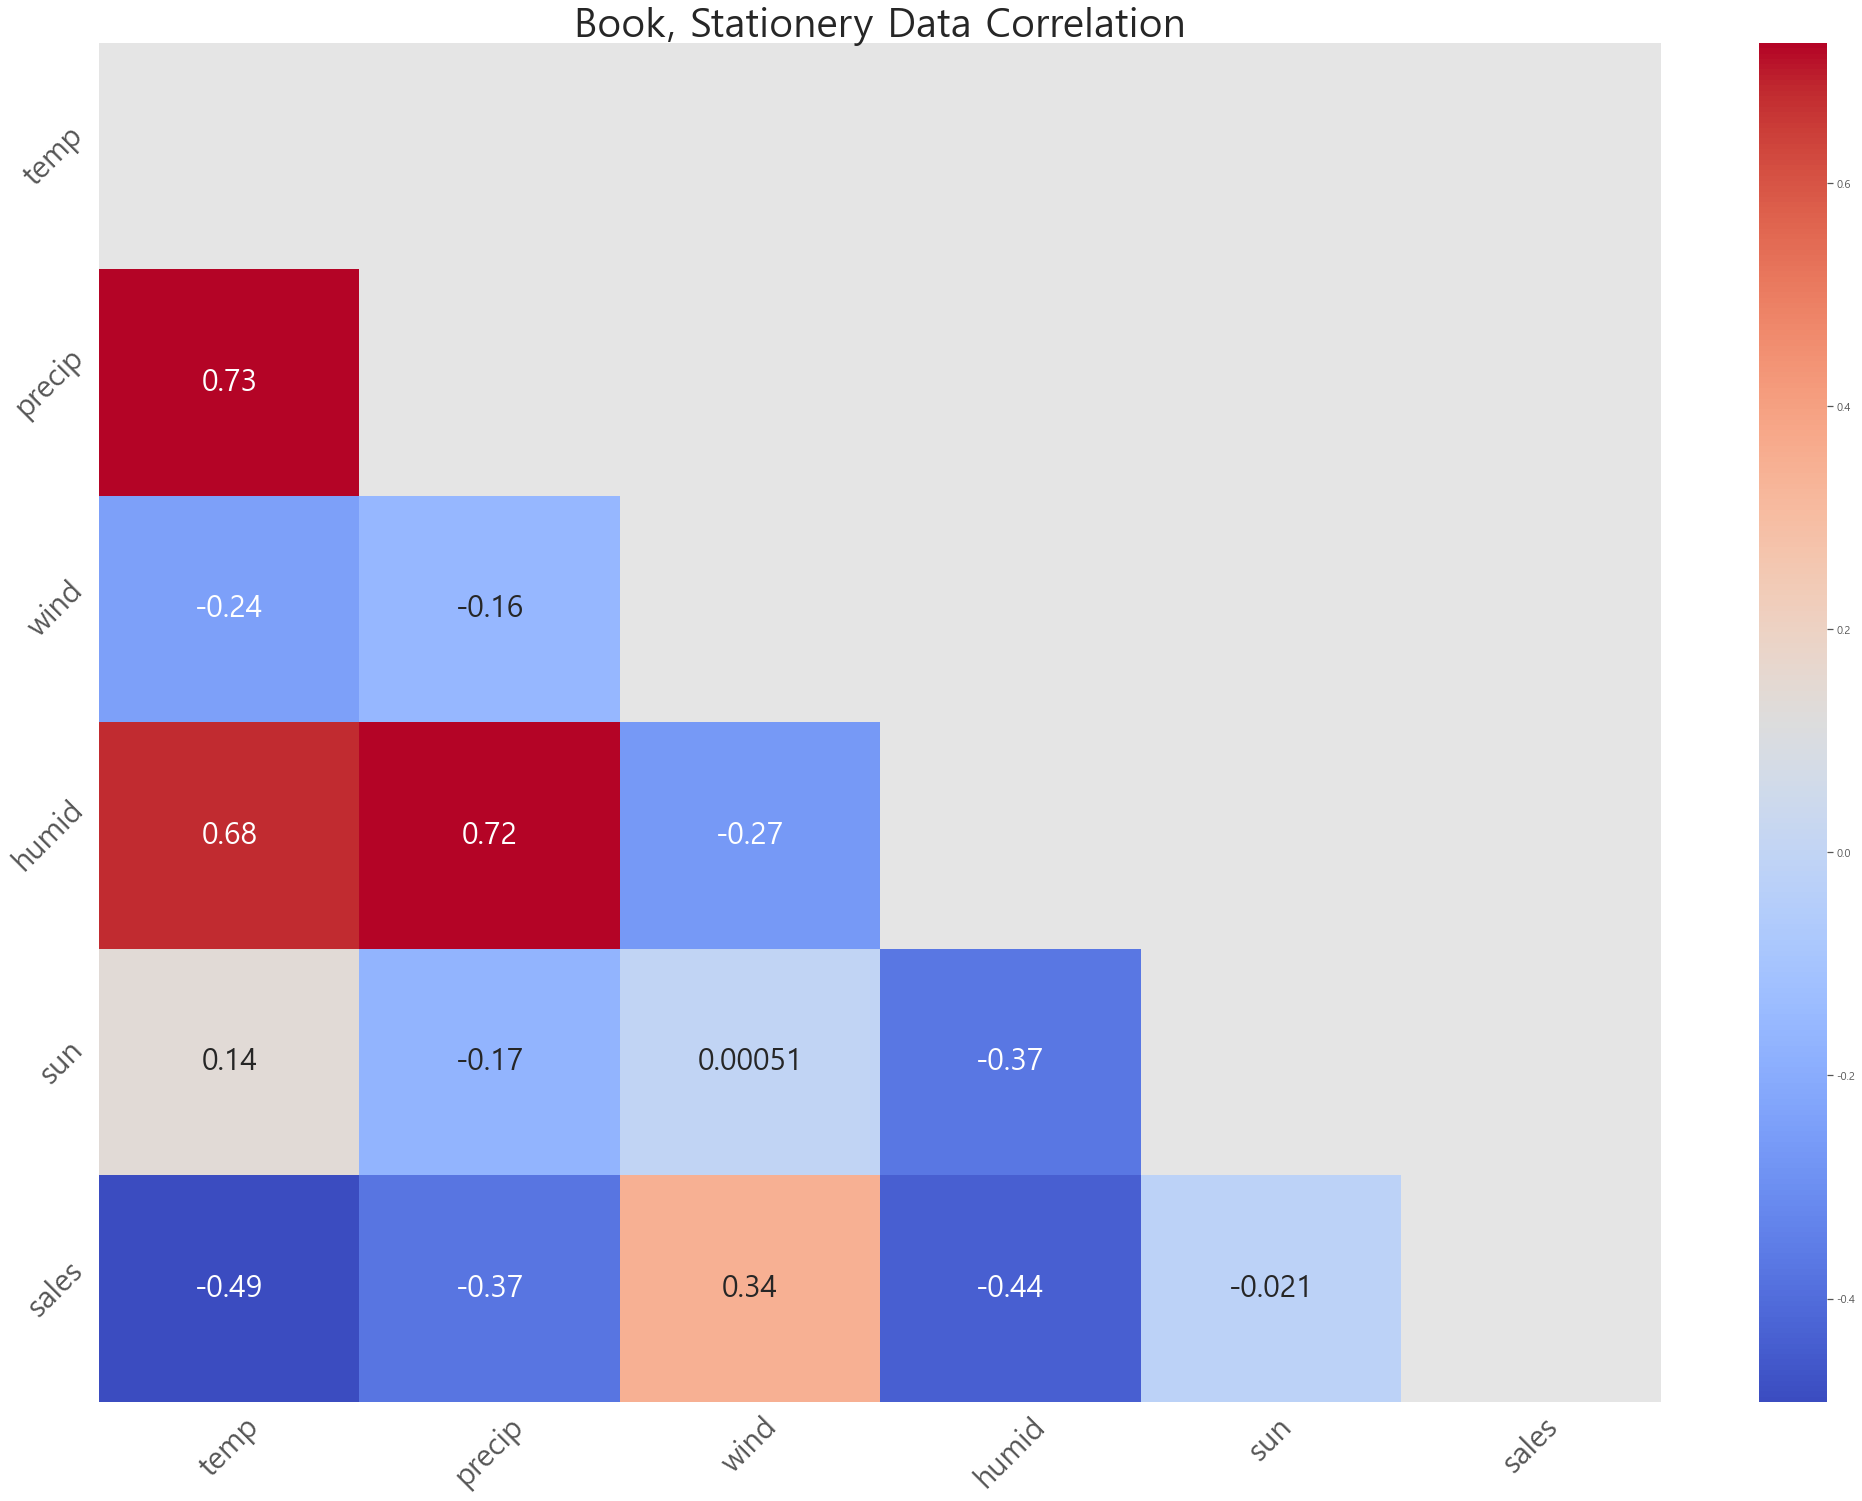

In [12]:
def plot_heatmap(df,title):
    plt.figure(figsize=(35,25))
    heat_table = df.corr(method="pearson")
    mask = np.zeros_like(heat_table)
    mask[np.triu_indices_from(mask)] = True
    heatmap_ax = sns.heatmap(heat_table, annot=True, annot_kws={"fontsize":30}, mask = mask, cmap='coolwarm')
    heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=30, rotation=45)
    heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=30, rotation=45)
    plt.title(f'{title} Data Correlation', fontsize=40)
    plt.show()

# 각 데이터에 따른 히트맵 분석 (마지막 증감여부 제외)
for i,p in enumerate(product_columns):
    plot_heatmap(df_dict[p].iloc[:,:-1], product_list[i])

# 3. Data Preprocessing
## 3.1 Data Training

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

results_by_seed = []

# for save best state
best_linear_model_dict = {p:None for p in product_columns}
best_linear_data_dict = {p:None for p in product_columns}
best_linear_result_dict = {p:None for p in product_columns}

best_logistic_model_dict = {p:None for p in product_columns}
best_logistic_data_dict = {p:None for p in product_columns}
best_logistic_result_dict = {p:None for p in product_columns}

for s in list(range(0, 50, 5)):
    results_mse = []
    results_r2 = []
    results_accuracy = []
    results_precision = []
    results_recall = []
    for i,p in enumerate(product_columns):
        X = df_dict[p].iloc[:,1:-2]
        Ys = df_dict[p].iloc[:,-2:]

        # Normalization
        X = (X - X.mean()) / X.std()
        Ys.iloc[:,0] = (Ys.iloc[:,0] - Ys.iloc[:,0].mean()) / Ys.iloc[:,0].std() 

        X_train, X_test, y_train, y_test = train_test_split(X, Ys,
                                         train_size = 0.9, 
                                         random_state = s)

        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train.iloc[:,0])
        
        logistic_model = LogisticRegression()
        logistic_model.fit(X_train, y_train.iloc[:,1])

        # test
        y_pred_lin = linear_model.predict(X_test)
        mse = mean_squared_error(y_test.iloc[:,0], y_pred_lin)
        r2 = r2_score(y_test.iloc[:,0], y_pred_lin)
        
        y_pred_logistic = logistic_model.predict(X_test)
        acc = accuracy_score(y_test.iloc[:,1], y_pred_logistic)
        precision = precision_score(y_test.iloc[:,1], y_pred_logistic)
        recall = recall_score(y_test.iloc[:,1], y_pred_logistic)

        # save result
        results_mse.append(mse)
        results_r2.append(r2)
        results_accuracy.append(acc)
        results_precision.append(precision)
        results_recall.append(recall)

        # update best models
        if best_linear_result_dict[p] is None:
            best_linear_model_dict[p] = linear_model
            best_linear_result_dict[p] = {"mse":mse,
                                          "r2":r2}
            best_linear_data_dict[p] = {"y_pred":y_pred_lin,
                                        "y_test":y_test.iloc[:,0]}

            best_logistic_result_dict[p] = logistic_model
            best_logistic_result_dict[p] = {"acc":acc,
                                            "precision":precision,
                                            "recall":recall}
            best_logistic_data_dict[p] = {"y_pred":y_pred_logistic,
                                          "y_test":y_test.iloc[:,1]}
        else:
            if best_linear_result_dict[p]['r2'] < r2:
                best_linear_model_dict[p] = linear_model
                best_linear_result_dict[p] = {"mse":mse,
                                              "r2":r2}
                best_linear_data_dict[p] = {"x_test":X_test,
                                            "y_pred":y_pred_lin,
                                            "y_test":y_test.iloc[:,0]}

            if best_logistic_result_dict[p]['acc'] < acc:
                best_logistic_result_dict[p] = logistic_model
                best_logistic_result_dict[p] = {"acc":acc,
                                                "precision":precision,
                                                "recall":recall}
                best_logistic_data_dict[p] = {"x_test":X_test,
                                              "y_pred":y_pred_logistic,
                                              "y_test":y_test.iloc[:,1]}

    results_df = pd.DataFrame({'r2':results_r2,
                               'mse':results_mse,
                               'acc':results_accuracy,
                               'precision':results_precision,
                               'recall':results_recall}, index=product_list)
    results_by_seed.append(results_df)

In [14]:
print("Seed 값 변경에 따른 평균 성능")
display(sum(results_by_seed)/ len(list(range(0, 50, 5))))

Seed 값 변경에 따른 평균 성능


,r2,mse,acc,precision,recall
Car,0.290330,0.654189,0.581818,0.638208,0.692656
Electronic,0.303492,0.676927,0.694118,0.684286,0.554643
Furniture,-0.084183,1.014962,0.623529,0.624192,0.755184
Cloth,0.002007,0.942085,0.682353,0.648971,0.863131
Bag,-0.031195,0.956021,0.483333,0.405714,0.501190
Food,0.310843,0.707868,0.647059,0.656667,0.370000
Medicine,0.203917,0.959341,0.552941,0.570343,0.937298
Cosmetics,0.301863,0.604254,0.541176,0.564073,0.903636
"Book, Stationery",0.094200,0.691257,0.747059,0.762262,0.694444


In [15]:
linear_best_results = results_by_seed[0]  #init
print("linear regression 모델 최고 성능 결과")
# r2 을 기준으로 최고 성능 찾기
for df in results_by_seed:
    for p in linear_best_results.index:
        if linear_best_results['r2'][p] < df['r2'][p]:
            linear_best_results.loc[p] = df.loc[p].copy()
display(linear_best_results.drop(columns=['acc','precision','recall']))

logistic_best_results = results_by_seed[0]  #init
print("logistic regression 모델 최고 성능 결과")
# acc 을 기준으로 최고 성능 찾기
for df in results_by_seed:
    for p in logistic_best_results.index:
        if logistic_best_results['acc'][p] < df['acc'][p]:
            logistic_best_results.loc[p] = df.loc[p].copy()
display(logistic_best_results.drop(columns=['r2','mse']))

linear regression 모델 최고 성능 결과


,r2,mse
Car,0.491763,0.577898
Electronic,0.427249,0.561100
Furniture,0.077406,0.683816
Cloth,0.305788,0.461304
Bag,0.440617,0.243194
Food,0.465208,0.575207
Medicine,0.425761,0.393968
Cosmetics,0.494345,0.478621
"Book, Stationery",0.447781,0.905807


logistic regression 모델 최고 성능 결과


,acc,precision,recall
Car,0.681818,0.750000,0.692308
Electronic,0.823529,0.800000,0.666667
Furniture,0.764706,0.666667,1.000000
Cloth,0.823529,0.800000,0.888889
Bag,0.750000,0.600000,0.750000
Food,0.764706,0.666667,0.400000
Medicine,0.705882,0.705882,1.000000
Cosmetics,0.647059,0.625000,1.000000
"Book, Stationery",0.882353,0.875000,0.875000


ROC AUC curve


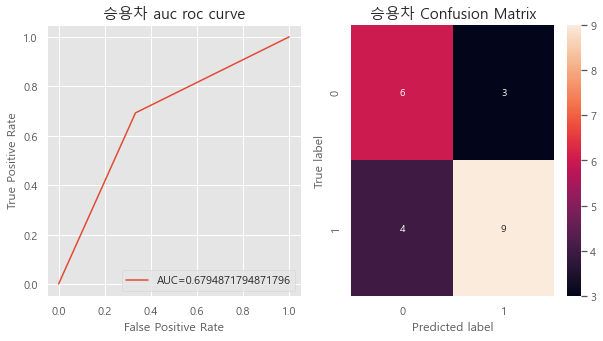

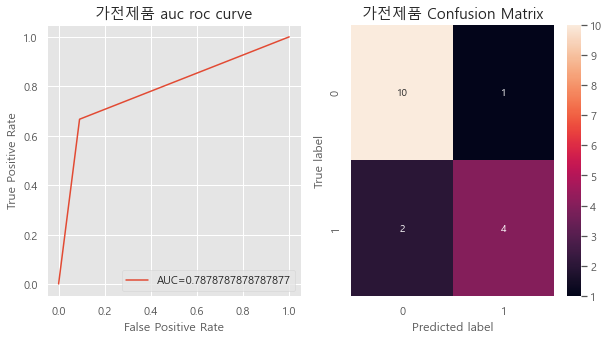

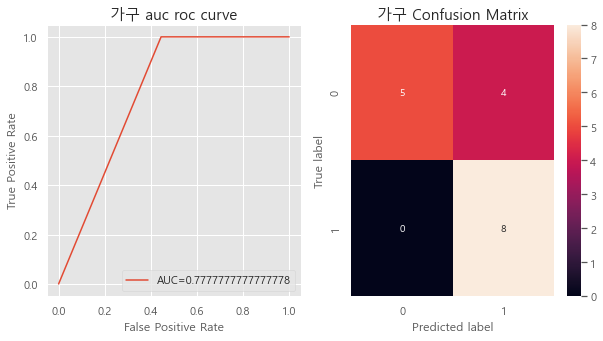

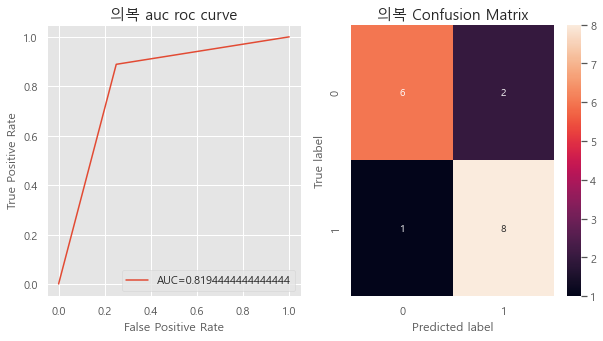

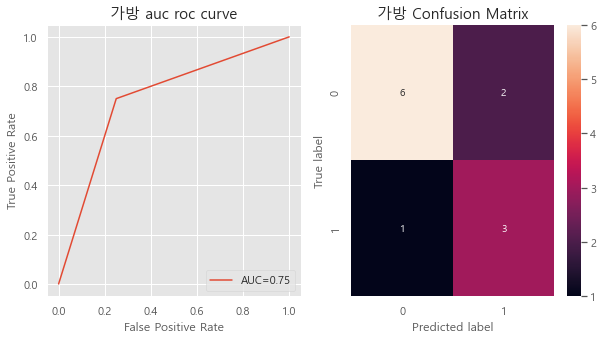

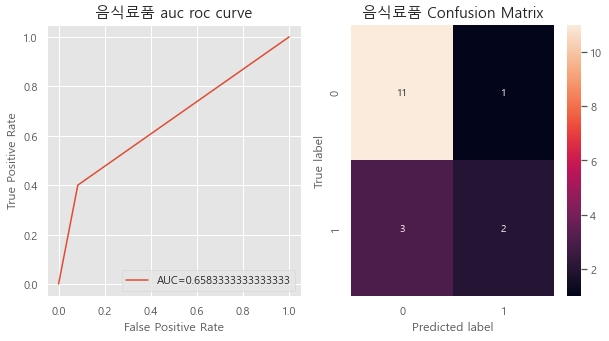

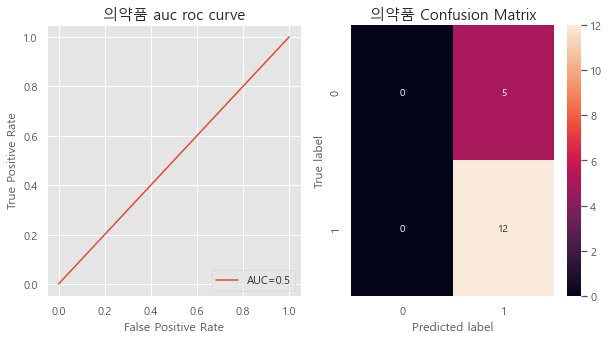

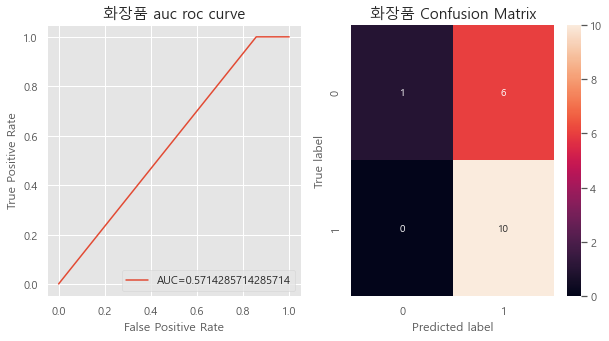

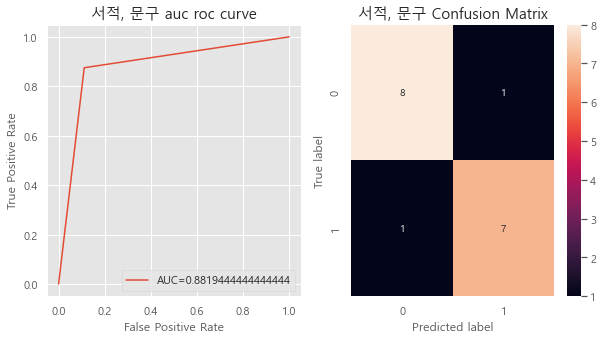

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
def plot_roc_auc_with_confusion_matrix(p):
    x_test, y_pred, y_test = list(best_logistic_data_dict[p].values())
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'AUC={roc_auc}')
    plt.title(f"{p} auc roc curve", fontsize=15)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

    ax = plt.subplot(1,2,2)
    sns.heatmap(data=cm, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{p} Confusion Matrix", fontsize=15)

    plt.show()
print('ROC AUC curve')
for p in best_logistic_model_dict.keys():
    plot_roc_auc_with_confusion_matrix(p)

In [17]:
print('학습된 모델의 Coefficient \n')
for p, model in best_linear_model_dict.items():
    print(f"{p} model Coefficient : {model.coef_}")
    print(f"{p} model Intercept : {model.intercept_}")
    print()

학습된 모델의 Coefficient 

승용차 model Coefficient : [-0.42451768  0.11138343 -0.17327244  0.5212437   0.74682552]
승용차 model Intercept : -0.01694895945907003

가전제품 model Coefficient : [-0.50307622  0.15670168 -0.33427862  0.59268398  0.41967926]
가전제품 model Intercept : -0.0029774831125803126

가구 model Coefficient : [-0.03955891 -0.04746178  0.04442463  0.07561861 -0.08560503]
가구 model Intercept : 0.011665460149112662

의복 model Coefficient : [-0.18867026 -0.1813348   0.01279304  0.03513856 -0.09435334]
의복 model Intercept : -0.006226118381210179

가방 model Coefficient : [-0.18899705  0.16597827 -0.34053058 -0.21217026 -0.02463545]
가방 model Intercept : -0.01628017030961126

음식료품 model Coefficient : [-0.36989898  0.03645606 -0.35713807  0.54596855  0.43867186]
음식료품 model Intercept : -0.021666092449750488

의약품 model Coefficient : [-0.52854366  0.11682369 -0.26641131  0.54284345  0.44796332]
의약품 model Intercept : 0.011690658979601313

화장품 model Coefficient : [-0.44876124  0.20345237 -0.50538926  0.27

# 4. 딥러닝을 이용한 주식 가격 예측
23일전 ~ 현재 주식 가격을 통해 다음날의 주식 가격을 예측하는 모델 학습

- Data : Weather data + Stock data (daily)
- Model : GRU model

Amorepacific Corporation Stock prediction training start


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Test Score: 12.601% MAPE


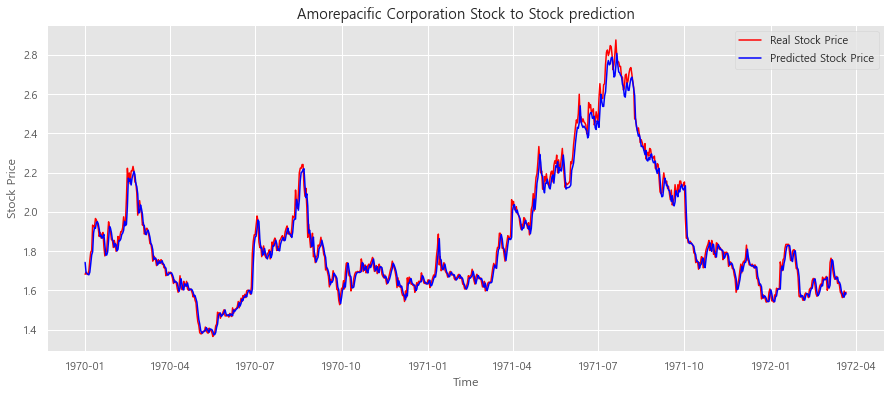

Amorepacific Corporation Stock prediction with weather data training start


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Test Score: 14.114% MAPE


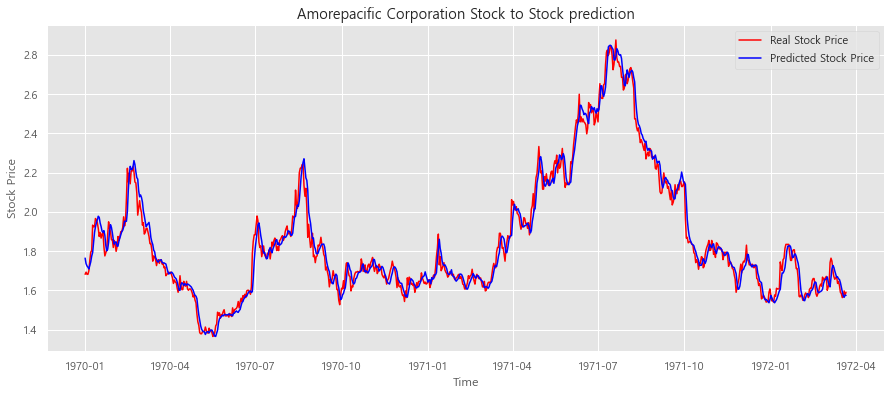

F&F Holdings Co Stock prediction training start


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Test Score: 18.822% MAPE


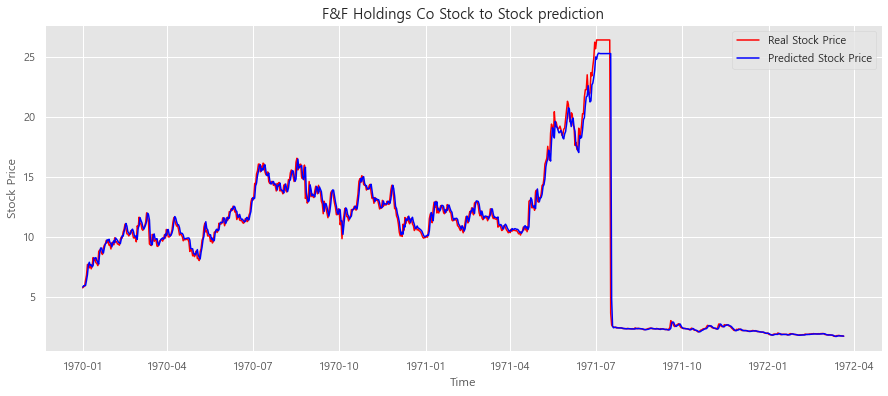

F&F Holdings Co Stock prediction with weather data training start


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Test Score: 24.621% MAPE


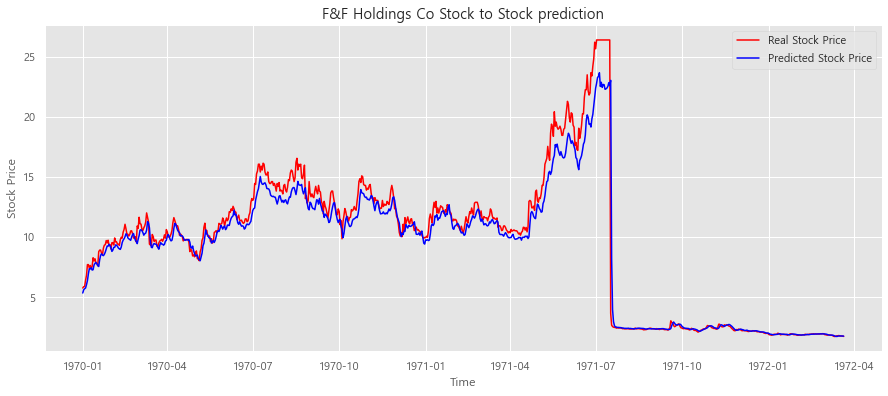

FILA Holdings Corporation Stock prediction training start


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


Test Score: 27.670% MAPE


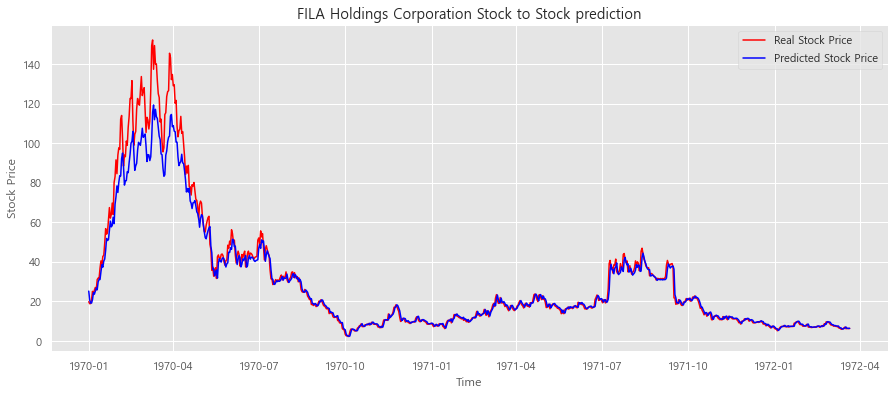

FILA Holdings Corporation Stock prediction with weather data training start


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Test Score: 29.446% MAPE


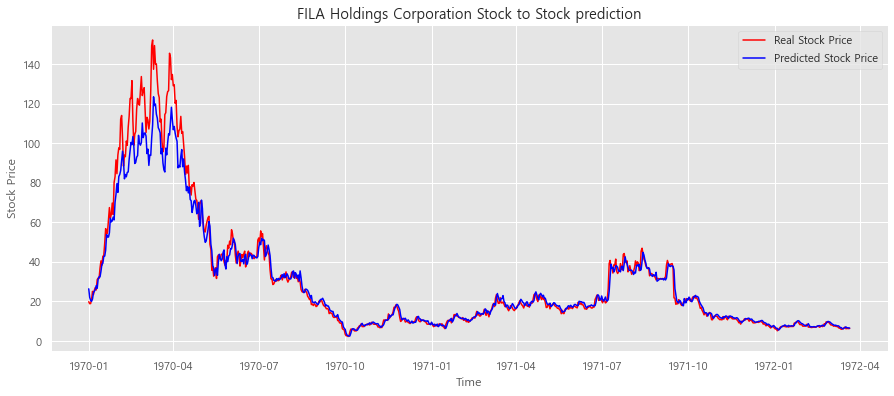

LG Electronics Inc Stock prediction training start


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Test Score: 28.821% MAPE


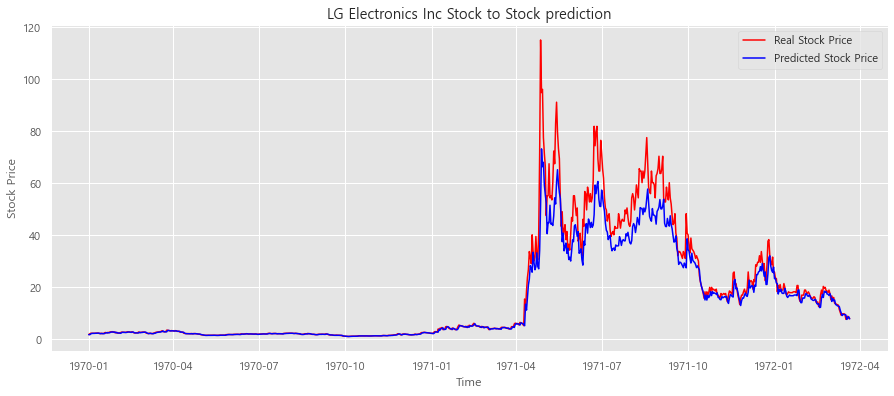

LG Electronics Inc Stock prediction with weather data training start


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


Test Score: 27.245% MAPE


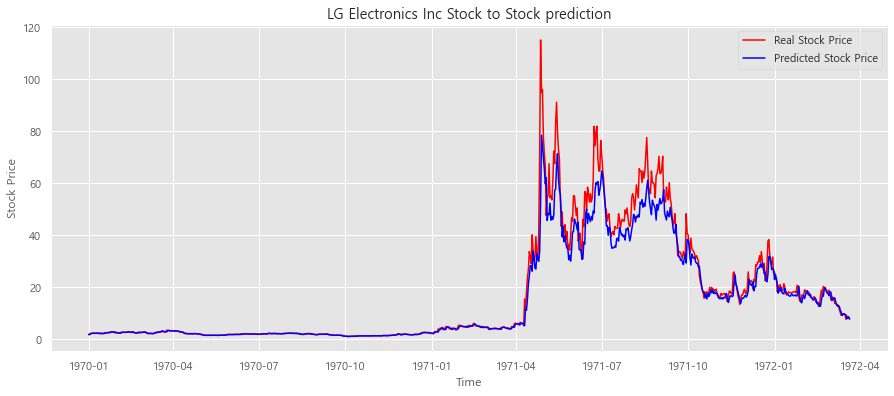

LG H&H Co Stock prediction training start


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Test Score: 19.769% MAPE


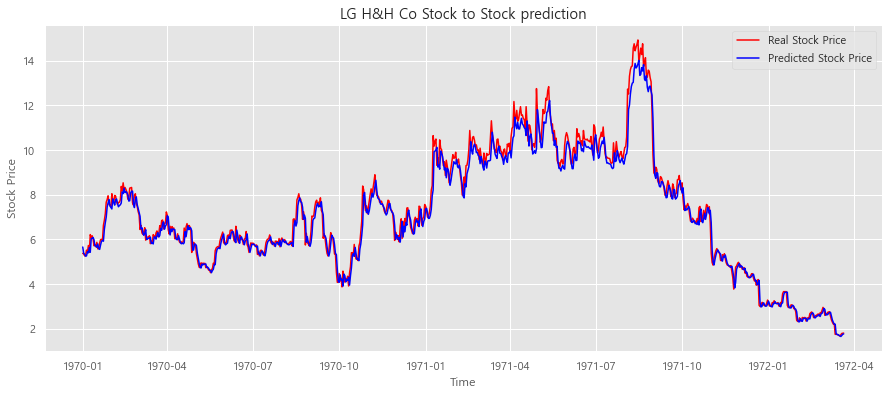

LG H&H Co Stock prediction with weather data training start


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Test Score: 26.543% MAPE


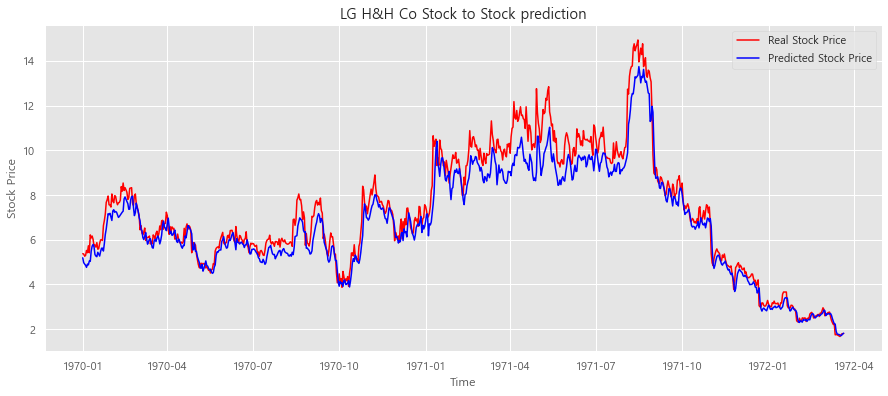

Samsung Electronics Co Stock prediction training start


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Test Score: 23.277% MAPE


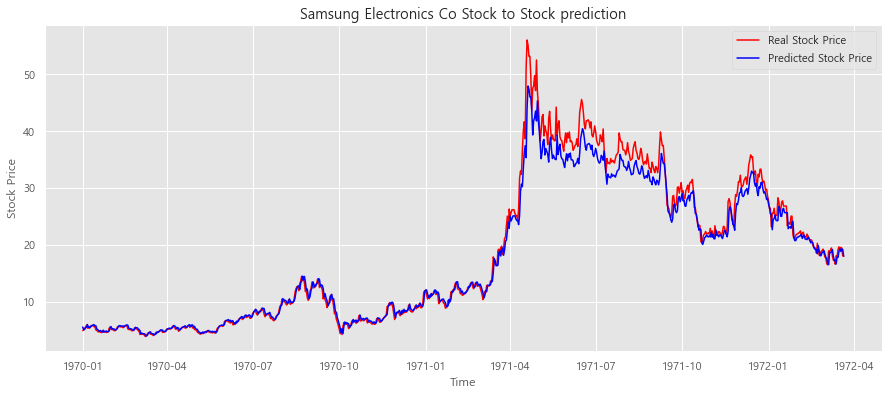

Samsung Electronics Co Stock prediction with weather data training start


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Test Score: 31.898% MAPE


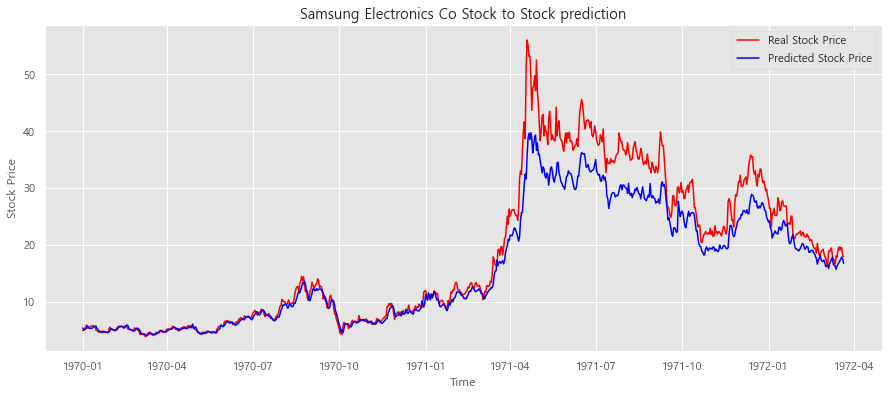

Youngone Corporation Stock prediction training start


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Test Score: 18.383% MAPE


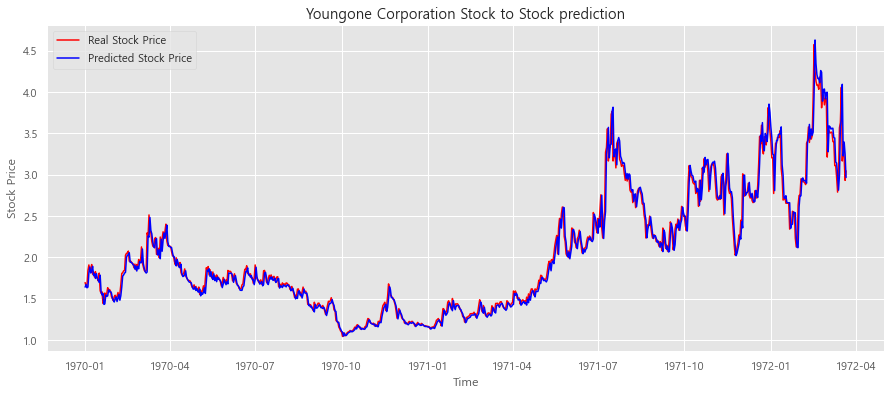

Youngone Corporation Stock prediction with weather data training start


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


Test Score: 20.011% MAPE


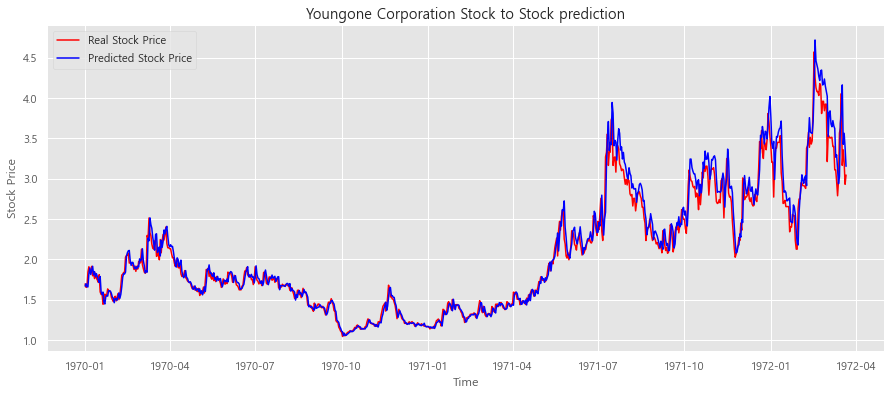

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_percentage_error
import math
from typing import List, Callable
from tqdm import tqdm

def load_data(company_name):
    # weather datas
    data_root = './data/daily'
    temp_df = pd.read_csv(f'{data_root}/Temperatures.csv', encoding='cp949')
    precip_df = pd.read_csv(f'{data_root}/Precipitation.csv', encoding='cp949').fillna(0)
    wind_df = pd.read_csv(f'{data_root}/Wind.csv', encoding='cp949')
    humidity_df = pd.read_csv(f'{data_root}/Humidity.csv', encoding='cp949')
    sunshine_df = pd.read_csv(f'{data_root}/Sunshine.csv', encoding='cp949')
    # merge weather data
    weather_df = temp_df.merge(precip_df).merge(wind_df).merge(humidity_df).merge(sunshine_df)
    weather_columns = ["평균기온", "강수량mm", "평균풍속ms", "평균습도rh","일조합"]
    selected_weather_df = weather_df[['일시']+weather_columns]

    # stock data
    stock_price_df = pd.read_csv(f'./data/stock/{company_name}.csv')
    stock_columns = ['Close']
    selected_stock_df = stock_price_df[['Date'] + stock_columns].dropna()

    # merge stock and weather data
    stock_weather_df = selected_weather_df.rename(columns={"일시":"Date"}).merge(selected_stock_df).dropna()

    # 주식 데이터를 log 스케일로 변경
    stock_weather_df['Close'] = np.log(1+stock_weather_df['Close'])

    # 2019년 기준으로 Train, Test 데이터 분리
    train_df = stock_weather_df[stock_weather_df['Date'] < '2019-01-01'].drop(columns='Date')
    test_df = stock_weather_df[stock_weather_df['Date'] >= '2019-01-01'].drop(columns='Date')

    # Normalize
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    return train_df, test_df

# 데이터
class StockDataset(Dataset):
    def __init__(self, df, t_dim, label:List = None,):
        super(StockDataset, self).__init__()
        self.df = df.reset_index(drop=True)
        self.t_dim = t_dim
        if label is None:
            label = df.columns
        self.label = label
        self.total_length = len(df) - (t_dim + 1)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        x = self.df.loc[idx: idx+self.t_dim-1].values
        y = self.df.loc[idx+self.t_dim][self.label].values
        return x, y

# 모델 정의
class StockModel(nn.Module):
    def __init__(self, input_dim, h_c=256, num_layers=2):
        super(StockModel, self).__init__()
        self.input_dim = input_dim
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=h_c, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=h_c, out_features=1)

    def forward(self, x):
        output, hn = self.rnn(x)
        return self.fc(output[:, -1, :])

# 학습과정 정의
def train(model, train_loader, criterion, optimizer,
          epochs=10, device=torch.device('cpu'), valid_loader=None,
          verbose=True):
    model = model.to(device)
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        # train
        for step, (x, y) in enumerate(train_loader):
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad()

            pred = model(x)
            loss =criterion(pred, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if verbose:
                if (step+1) % 100 == 0:
                    print(f"{epoch+1} epoch : {step+1 :5d}step - loss={running_loss/(step+1)}")
        if verbose:
            print(f"{epoch+1} epoch : {step+1 :5d}step - loss={running_loss/(step+1)}")

        # valid
        if valid_loader is not None:
            valid_loss = 0
            for step, (x, y) in enumerate(valid_loader):
                x, y = x.float().to(device), y.float().to(device)
                pred = model(x)
                pred = torch.exp(pred) + 1
                y = torch.exp(y) + 1
                valid_loss += mean_absolute_percentage_error(y.detach().cpu().numpy().squeeze(),
                                                             pred.detach().cpu().numpy().squeeze())
            if verbose:
                print(f"valid_loss={valid_loss}")

    return model

def plot_result(model, test_ds, title_name:str, device=torch.device('cpu')):
    model_y_pred = []
    model_y_true = []
    model.eval()
    for x, y in DataLoader(test_ds, batch_size=1):
        y_pred = model(x.float().to(device))
        model_y_pred.append(y_pred.detach().cpu().numpy())
        model_y_true.append(y.detach().cpu().numpy())
    test_y_pred = np.exp(np.concatenate(model_y_pred)).squeeze() +1
    test_y_true = np.exp(np.concatenate(model_y_true)).squeeze() + 1
    testScore = math.sqrt(mean_absolute_percentage_error(test_y_true, test_y_pred))
    print(f'Test Score: {testScore*100:.3f}% MAPE')

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()

    axes.plot(np.arange(len(test_y_true)), test_y_true, color = 'red', label = 'Real Stock Price')
    axes.plot(np.arange(len(test_y_true)), test_y_pred, color = 'blue', label = 'Predicted Stock Price')
    plt.title(f'{title_name}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


companies = ['Amorepacific Corporation','F&F Holdings Co','FILA Holdings Corporation','LG Electronics Inc','LG H&H Co','Samsung Electronics Co','Youngone Corporation']
batch_size=32
t_dim =  24
epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for i, company in enumerate(companies):
    train_data, test_data = load_data(company)

    print(f'{company} Stock prediction training start')
    # stock to stock prediction
    train_ds = StockDataset(train_data[['Close']], t_dim=t_dim, label=['Close'])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = StockDataset(test_data[['Close']], t_dim=t_dim, label=['Close'])
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    model = StockModel(1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = train(model, train_loader, criterion, optimizer, epochs,
                  valid_loader=test_loader, device=device, verbose=False)
    plot_result(model, test_ds, f'{company} Stock to Stock prediction', device=device)

    print(f'{company} Stock prediction with weather data training start')
    # stock to stock prediction
    train_ds = StockDataset(train_data, t_dim=t_dim, label=['Close'])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = StockDataset(test_data, t_dim=t_dim, label=['Close'])
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    model = StockModel(len(train_data.columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model = train(model, train_loader, criterion, optimizer, epochs,
                  valid_loader=test_loader, device=device, verbose=False)
    plot_result(model, test_ds, f'{company} Stock to Stock prediction', device=device)
